This notebook plots BDT value of darkphoton to electron pair and to muon pair separately. **Triggered only**.

In [11]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
from awkward import JaggedArray

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json

dataset4mu_ = json.load(open('../Samples/signal_4mu.json'))
dataset2mu2e_ = json.load(open('../Samples/signal_2mu2e.json'))

dataset=dict(
    sig2mu2e={'files': [], 'treename': 'ffNtuplizer/ffNtuple'},
)

for k in dataset2mu2e_: dataset['sig2mu2e']['files'].extend(dataset2mu2e_[k])

In [3]:
class LeptonJetsProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal datasets')
        type_axis    = hist.Cat('typed', 'matched decay product')
        mva_axis     = hist.Bin('mva', 'BDT value', 50, -10, 10)
    
        self._accumulator = processor.dict_accumulator({
            "mva": hist.Hist("#counts/0.4", dataset_axis, mva_axis, type_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df['dataset']
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'].content,
            py=df['pfjet_p4.fCoordinates.fY'].content,
            pz=df['pfjet_p4.fCoordinates.fZ'].content,
            energy=df['pfjet_p4.fCoordinates.fT'].content,
            mva=df['pfjet_mva'].content,
        )
        genparticles = JaggedCandidateArray.candidatesfromcounts(
            df['gen_p4'],
            px=df['gen_p4.fCoordinates.fX'].content,
            py=df['gen_p4.fCoordinates.fY'].content,
            pz=df['gen_p4.fCoordinates.fZ'].content,
            energy=df['gen_p4.fCoordinates.fT'].content,
            pid=df['gen_pid'].content,
        )
        darkphotons = genparticles[genparticles.pid==32]
        dp_el = darkphotons[df['gen2_pid']==11]
        dp_mu = darkphotons[df['gen2_pid']==13]
        matchmask_el = leptonjets.match(dp_el, deltaRCut=0.3)
        matchmask_mu = leptonjets.match(dp_mu, deltaRCut=0.3)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        
        leptonjets_el = leptonjets[matchmask_el][metfiltermask&triggermask]
        leptonjets_mu = leptonjets[matchmask_mu][metfiltermask&triggermask]
        
        output['mva'].fill(dataset=dataset, typed='electron type', mva=leptonjets_el.mva.flatten())
        output['mva'].fill(dataset=dataset, typed='muon type', mva=leptonjets_mu.mva.flatten())
        
        return output
    
    def postprocess(self, accumulator):
        return accumulator

In [4]:
output = processor.run_uproot_job(dataset,
                                  treename=None,
                                  processor_instance=LeptonJetsProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12,),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 156/156 [00:19<00:00,  8.18items/s]


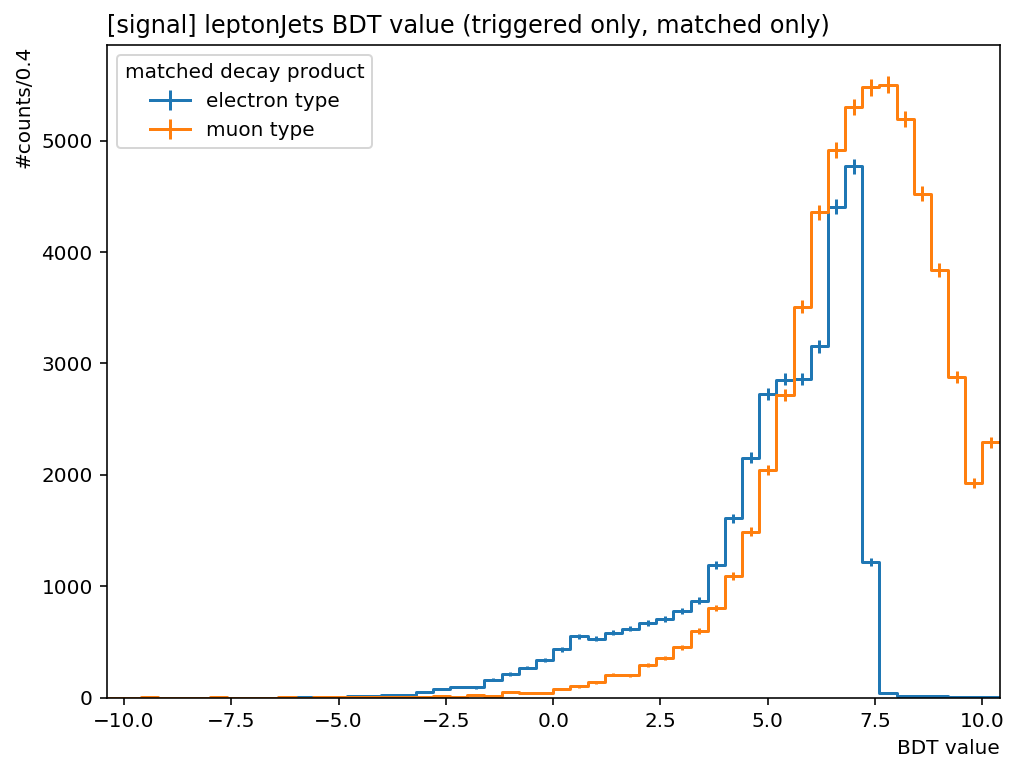

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
hist.plot1d(output['mva'].project('dataset'), overlay='typed', ax=ax, overflow='all')

ax.set_title('[signal] leptonJets BDT value (triggered only, matched only)', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

### BDT score per category

In [6]:
scale4mu_ = json.load(open('../Samples/signal_4mu_scale.json'))
scale2mu2e_ = json.load(open('../Samples/signal_2mu2e_scale.json'))
lumi = 60.432

scales={}
for k in scale4mu_:
    scales[f'4mu/{k}'] = lumi * scale4mu_[k]
for k in scale2mu2e_:
    scales[f'2mu2e/{k}'] = lumi * scale2mu2e_[k]

datasetsplit = {}
for k in dataset4mu_:
    datasetsplit[f'4mu/{k}'] = dict(files=dataset4mu_[k], treename='ffNtuplizer/ffNtuple')
for k in dataset2mu2e_:
    datasetsplit[f'2mu2e/{k}'] = dict(files=dataset2mu2e_[k], treename='ffNtuplizer/ffNtuple')

In [9]:
class BDTScoreProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'datasets')
        mva0_axis    = hist.Bin('mva0', 'leading BDT value', 4, 0, 4)
        mva1_axis    = hist.Bin('mva1', 'subleading BDT value', 4, 0, 4)
        self._accumulator = processor.dict_accumulator({
            'mvaCR': hist.Hist("#counts/bin", dataset_axis, mva0_axis, mva1_axis),
            'mvaSR': hist.Hist("#counts/bin", dataset_axis, mva0_axis, mva1_axis),
        })
        self.pucorrs = get_pu_weights_function()
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        nvtx = df['npv']
        pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
        wgts.add('pileup', pu, puUp, puDown)
        
        metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
        wgts.add('metfilters', metfiltermask)
        triggermask = np.logical_or.reduce([df[tp] for tp in Triggers])
        wgts.add('trigger', triggermask)
        
        weight = wgts.weight()
        ########################
        dataset = df['dataset']

        nef=(df['pfjet_neutralEmE']+df['pfjet_neutralHadronE'])/df['pfjet_p4.fCoordinates.fT']
        rawmva=df['pfjet_mva']
        _neutral = nef>0.999
        _tracked = ~_neutral
        mva_neutral = (rawmva*_neutral > 2.010711908340454).astype(int) +\
                      (rawmva*_neutral > 5.317723751068115).astype(int) +\
                      (rawmva*_neutral > 6.909248352050781).astype(int)
        mva_tracked = (rawmva*_tracked > 2.3958024978637695).astype(int) +\
                      (rawmva*_tracked > 5.316260814666748).astype(int) +\
                      (rawmva*_tracked > 7.421047687530518).astype(int)
        mva = mva_neutral+mva_tracked
            
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            mva=mva
        )
        
        # control region selections
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        if not dileptonjets.size: return output
        
        leadlj = dileptonjets[dileptonjets.pt.argmax()]
        subllj = dileptonjets[JaggedArray.fromfolding(dileptonjets.pt.argsort()[:,1], 1)]
        controlregion = np.abs(leadlj.p4.delta_phi(subllj.p4))<2.5
        signalregion = ~controlregion
        
        output['mvaCR'].fill(dataset=dataset,
                             mva0=leadlj[controlregion].mva.flatten(),
                             mva1=subllj[controlregion].mva.flatten(),
                             weight=wgt[controlregion.flatten()]
                            )
        output['mvaSR'].fill(dataset=dataset,
                             mva0=leadlj[signalregion].mva.flatten(),
                             mva1=subllj[signalregion].mva.flatten(),
                             weight=wgt[signalregion.flatten()]
                            )
        return output
    
    def postprocess(self, accumulator):
        for k in accumulator:
            accumulator[k].scale(scales, axis='dataset')
        return accumulator

In [10]:
output = processor.run_uproot_job(datasetsplit,
                                  treename=None,
                                  processor_instance=BDTScoreProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 312/312 [00:20<00:00, 18.31items/s]


In [12]:
dsids = output['mvaCR'].identifiers('dataset')
dsids

[<StringBin (2mu2e/mXX-1000_mA-0p25_lxy-0p3) instance at 0x7f5340d4f9e8>,
 <StringBin (2mu2e/mXX-1000_mA-0p25_lxy-300) instance at 0x7f53427c9160>,
 <StringBin (2mu2e/mXX-1000_mA-0p8_lxy-300) instance at 0x7f5340d58e10>,
 <StringBin (2mu2e/mXX-1000_mA-1p2_lxy-300) instance at 0x7f534273ecc0>,
 <StringBin (2mu2e/mXX-1000_mA-2p5_lxy-300) instance at 0x7f5340d3deb8>,
 <StringBin (2mu2e/mXX-1000_mA-5_lxy-300) instance at 0x7f53427a0470>,
 <StringBin (2mu2e/mXX-100_mA-0p25_lxy-300) instance at 0x7f5340d54f98>,
 <StringBin (2mu2e/mXX-100_mA-0p8_lxy-300) instance at 0x7f5340d558d0>,
 <StringBin (2mu2e/mXX-100_mA-1p2_lxy-300) instance at 0x7f53407b9ac8>,
 <StringBin (2mu2e/mXX-100_mA-2p5_lxy-300) instance at 0x7f53427abbe0>,
 <StringBin (2mu2e/mXX-100_mA-5_lxy-0p3) instance at 0x7f534278b748>,
 <StringBin (2mu2e/mXX-100_mA-5_lxy-300) instance at 0x7f5375c9ce10>,
 <StringBin (2mu2e/mXX-150_mA-0p25_lxy-300) instance at 0x7f5340d54a90>,
 <StringBin (2mu2e/mXX-150_mA-0p8_lxy-300) instance at 0x7f5

In [59]:
def makeplot(datasettag):
    """
    Same plotting routine for all following plots.
    """
    
    dsbin = [x for x in dsids if x.name==datasettag][0]

    fig, axes = plt.subplots(1,2,figsize=(16,6), gridspec_kw={'wspace': 0.05}, sharex=True, sharey=True)
    hist.plot2d(output['mvaCR'].project('dataset', dsbin),
                xaxis='mva1', density=False, ax=axes.flat[0],
                patch_opts=dict(norm=LogNorm()),
                text_opts={'format': '%.2g', 'fontsize': 'large'})
    axes.flat[0].set_title('[control region] '+str(dsbin), x=0.0, ha="left")

    hist.plot2d(output['mvaSR'].project('dataset', dsbin),
                xaxis='mva1', density=False, ax=axes.flat[1],
                patch_opts=dict(norm=LogNorm()),
                text_opts={'format': '%.2g', 'fontsize': 'large'})
    axes.flat[1].set_title('[signal region] '+str(dsbin), x=0.0, ha="left")

    tickpos = [0.5, 1.5, 2.5, 3.5]
    ticklbl = ['B', 'Loose', 'Medium', 'Tight']

    for i, ax in enumerate(axes.flat):
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")

        ax.set_xticks(tickpos)
        ax.set_xticklabels(ticklbl)
        ax.set_yticks(tickpos)
        ax.set_yticklabels(ticklbl)

## 4mu

### mXX=100 mA=0.25 lxy=300
4mu/mXX-100_mA-0p25_lxy-300

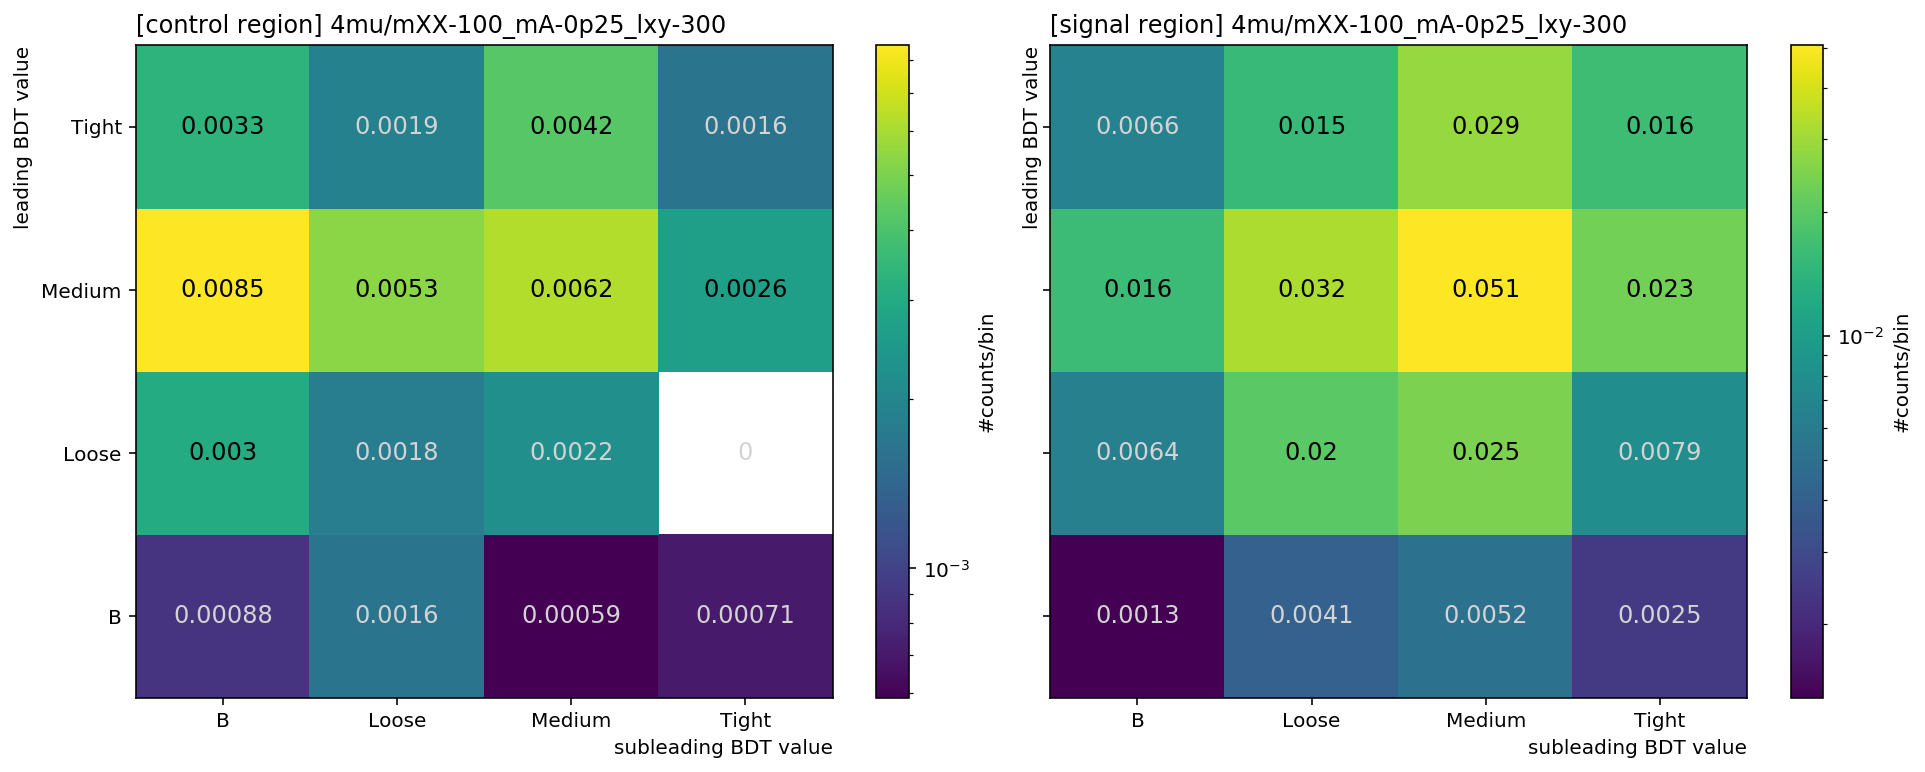

In [60]:
makeplot('4mu/mXX-100_mA-0p25_lxy-300')

### mXX=100 mA=1.2 lxy=300
4mu/mXX-100_mA-1p2_lxy-300

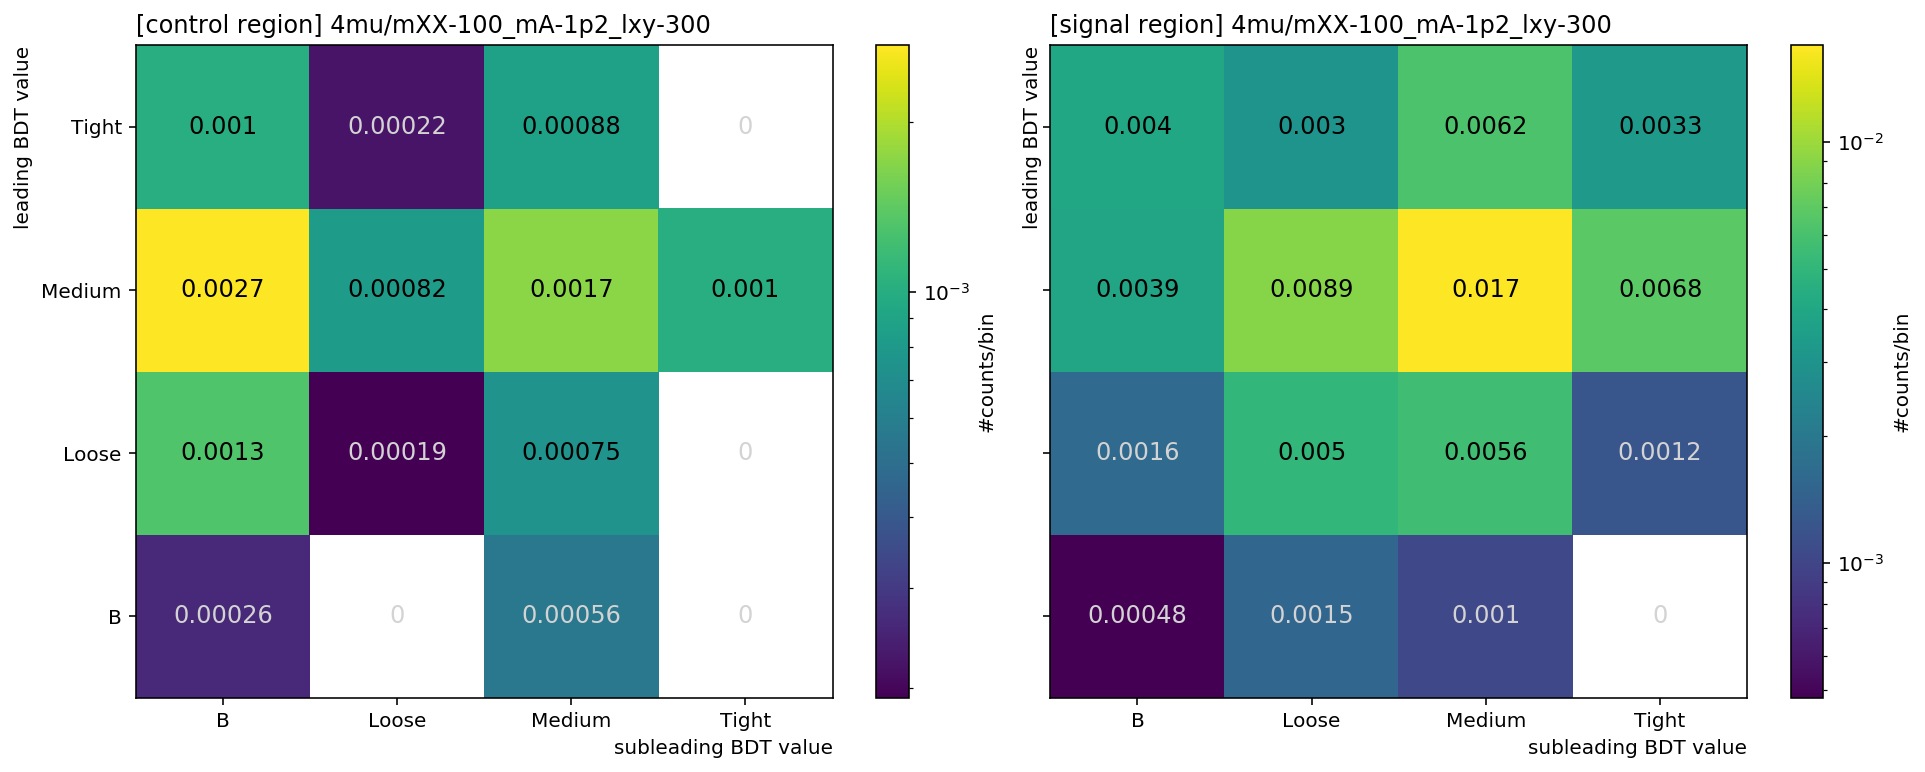

In [61]:
makeplot('4mu/mXX-100_mA-1p2_lxy-300')

### mXX=100 mA=5 lxy=300
4mu/mXX-100_mA-5_lxy-300

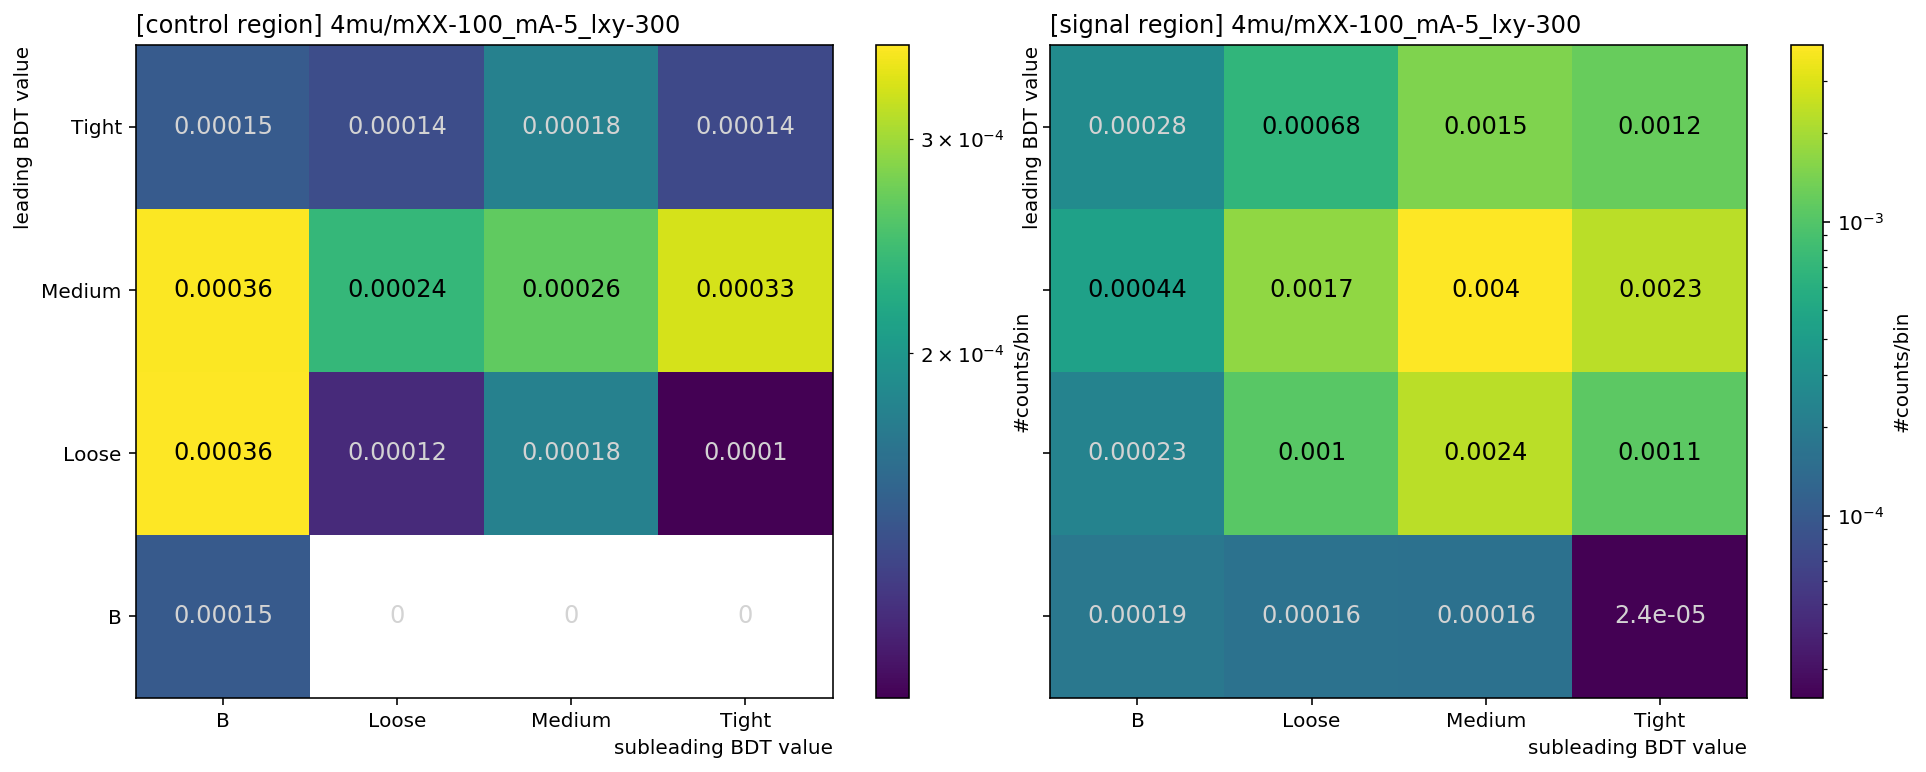

In [62]:
makeplot('4mu/mXX-100_mA-5_lxy-300')

### mXX=100 mA=5 lxy=0.3
4mu/mXX-100_mA-5_lxy-0p3

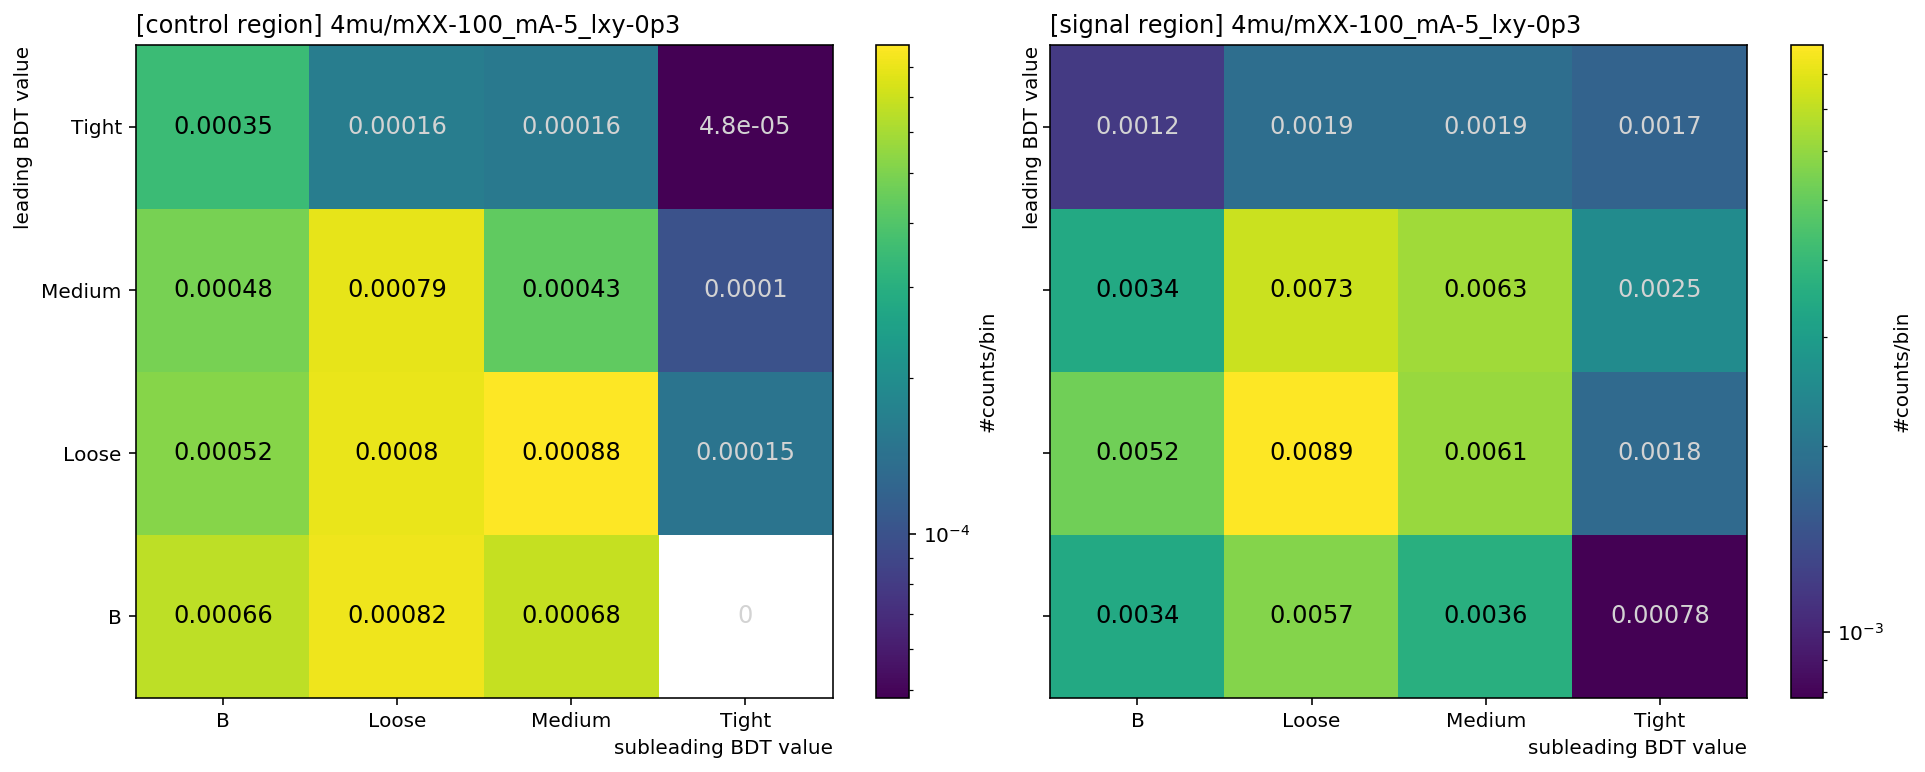

In [63]:
makeplot('4mu/mXX-100_mA-5_lxy-0p3')

### mXX=150 mA=0.25 lxy=300
4mu/mXX-150_mA-0p25_lxy-300

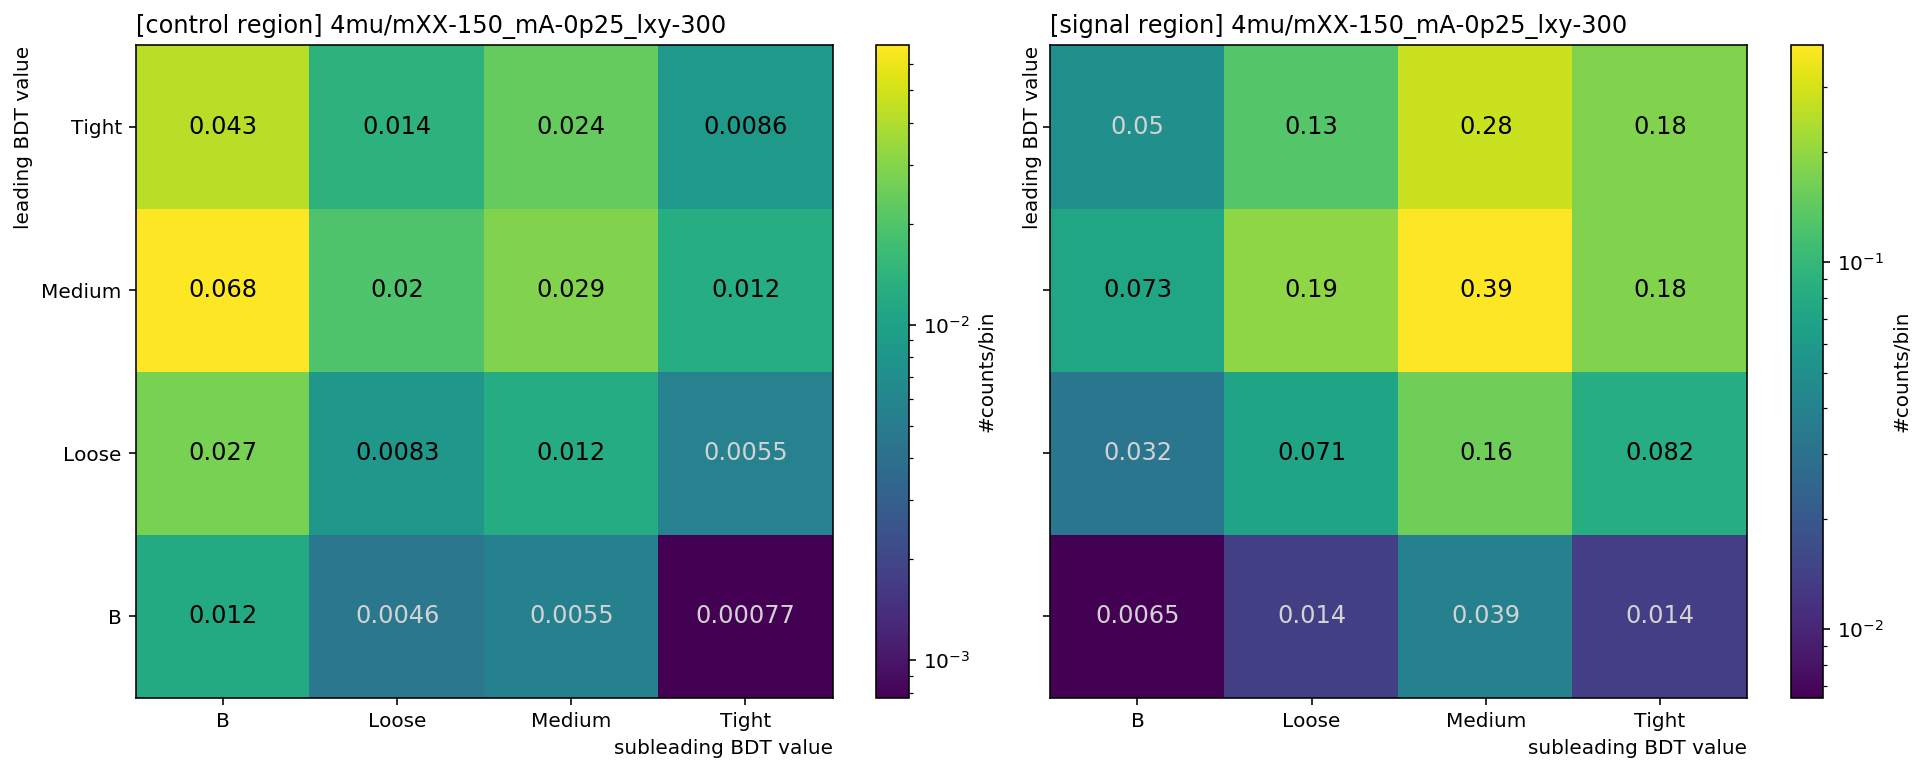

In [65]:
makeplot('4mu/mXX-150_mA-0p25_lxy-300')

### mXX=150 mA=1.2 lxy=300
4mu/mXX-150_mA-1p2_lxy-300

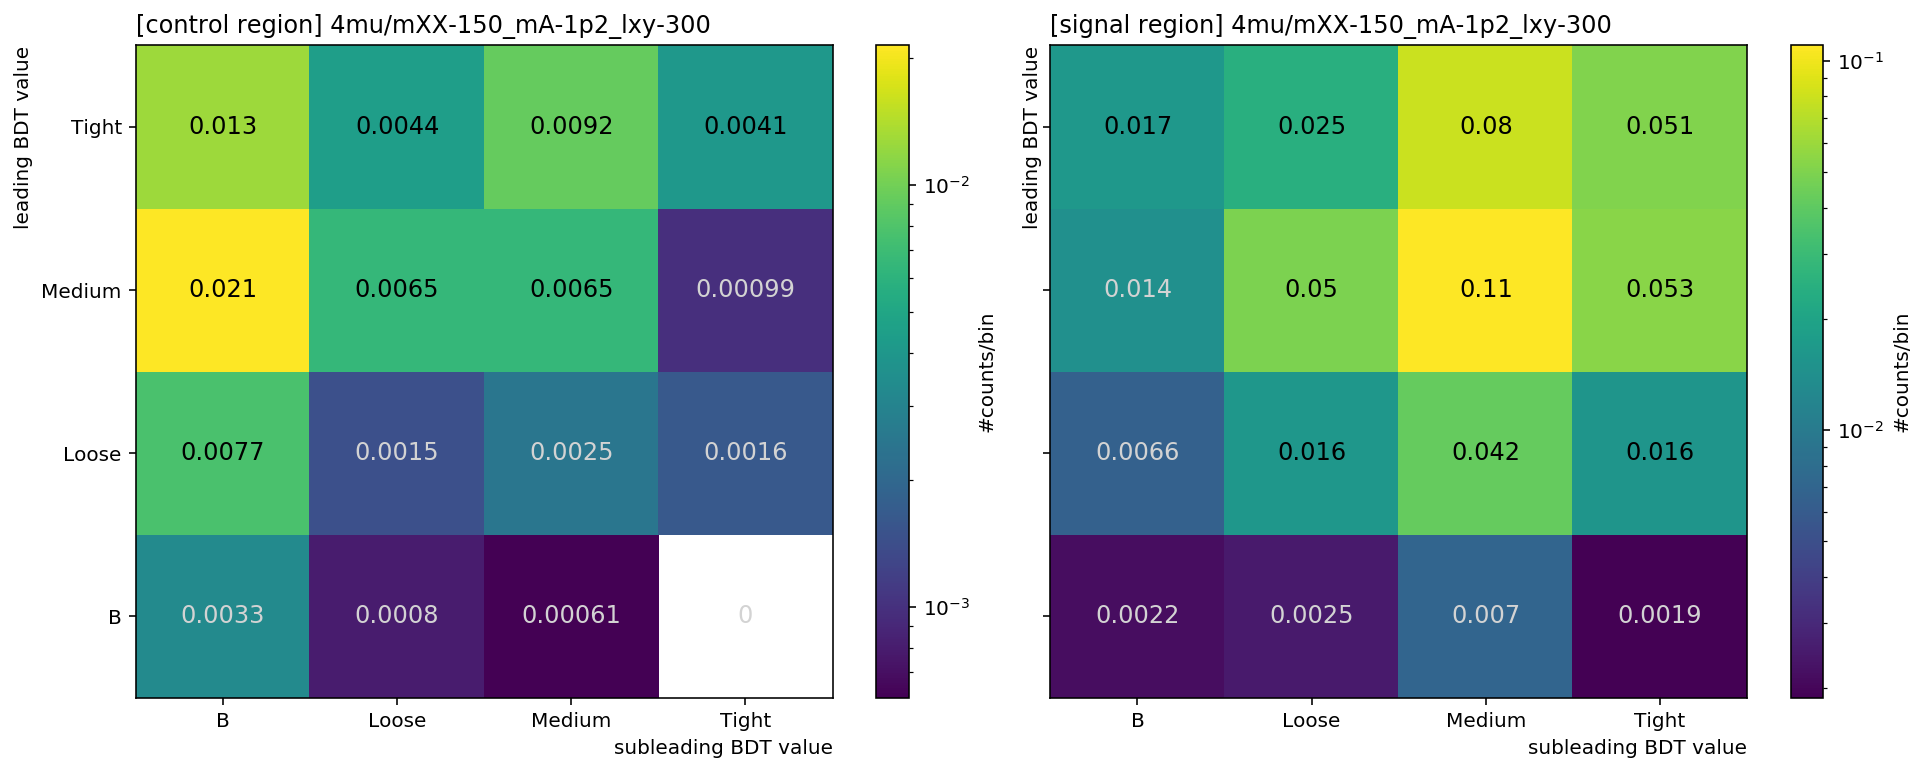

In [66]:
makeplot('4mu/mXX-150_mA-1p2_lxy-300')

### mXX=150 mA=5 lxy=300
4mu/mXX-150_mA-5_lxy-300

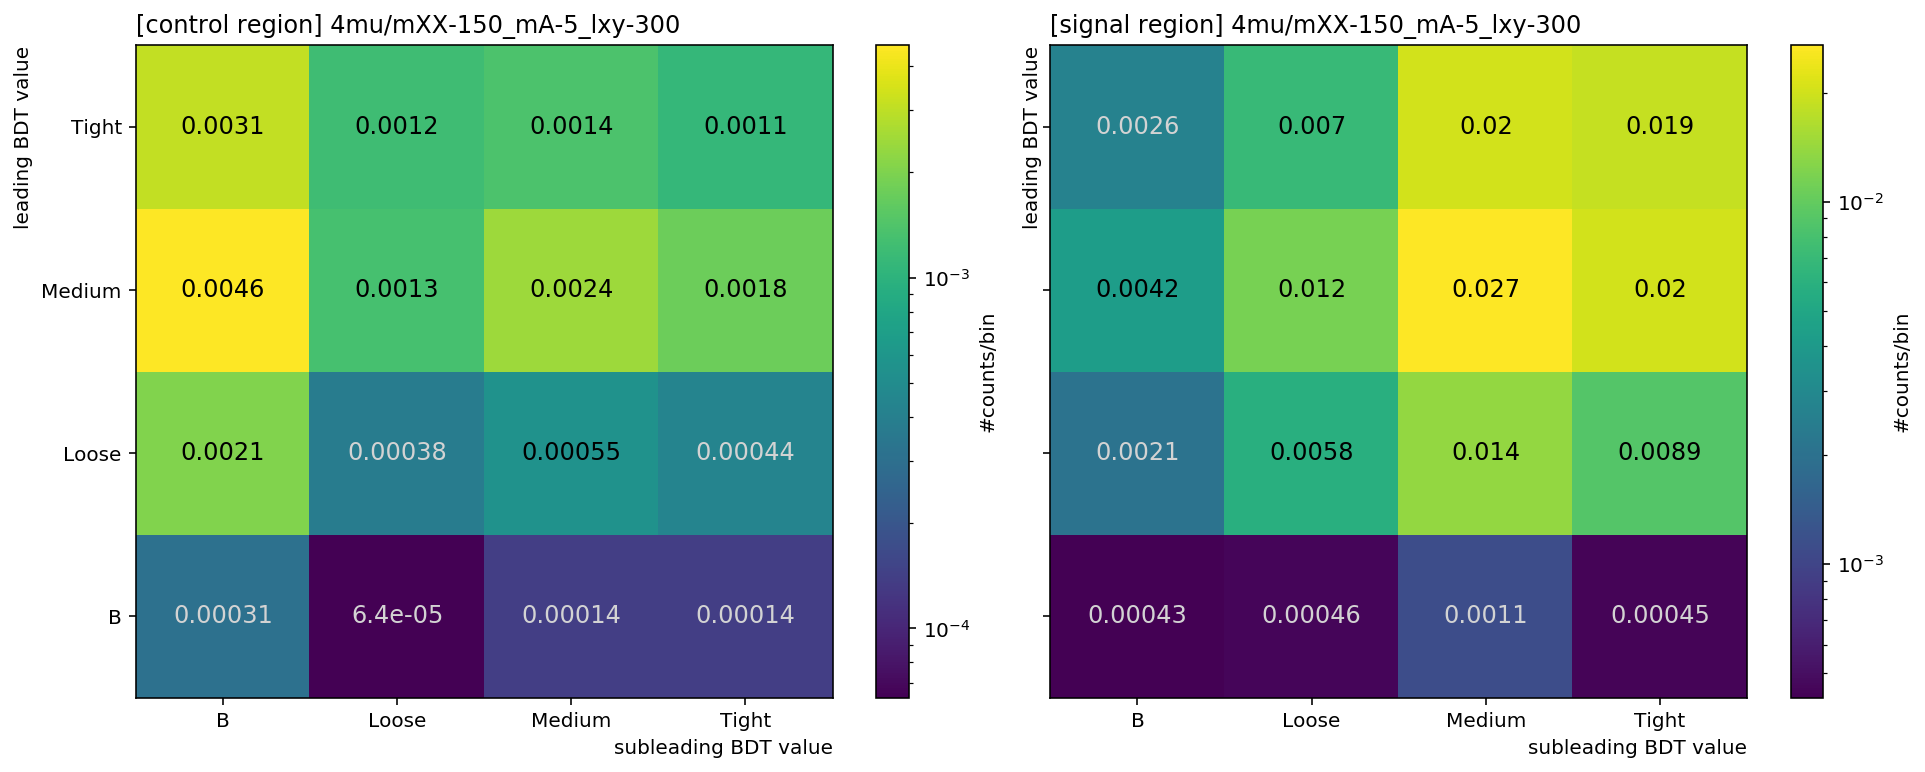

In [67]:
makeplot('4mu/mXX-150_mA-5_lxy-300')

### mXX=200 mA=0.25 lxy=300
4mu/mXX-200_mA-0p25_lxy-300

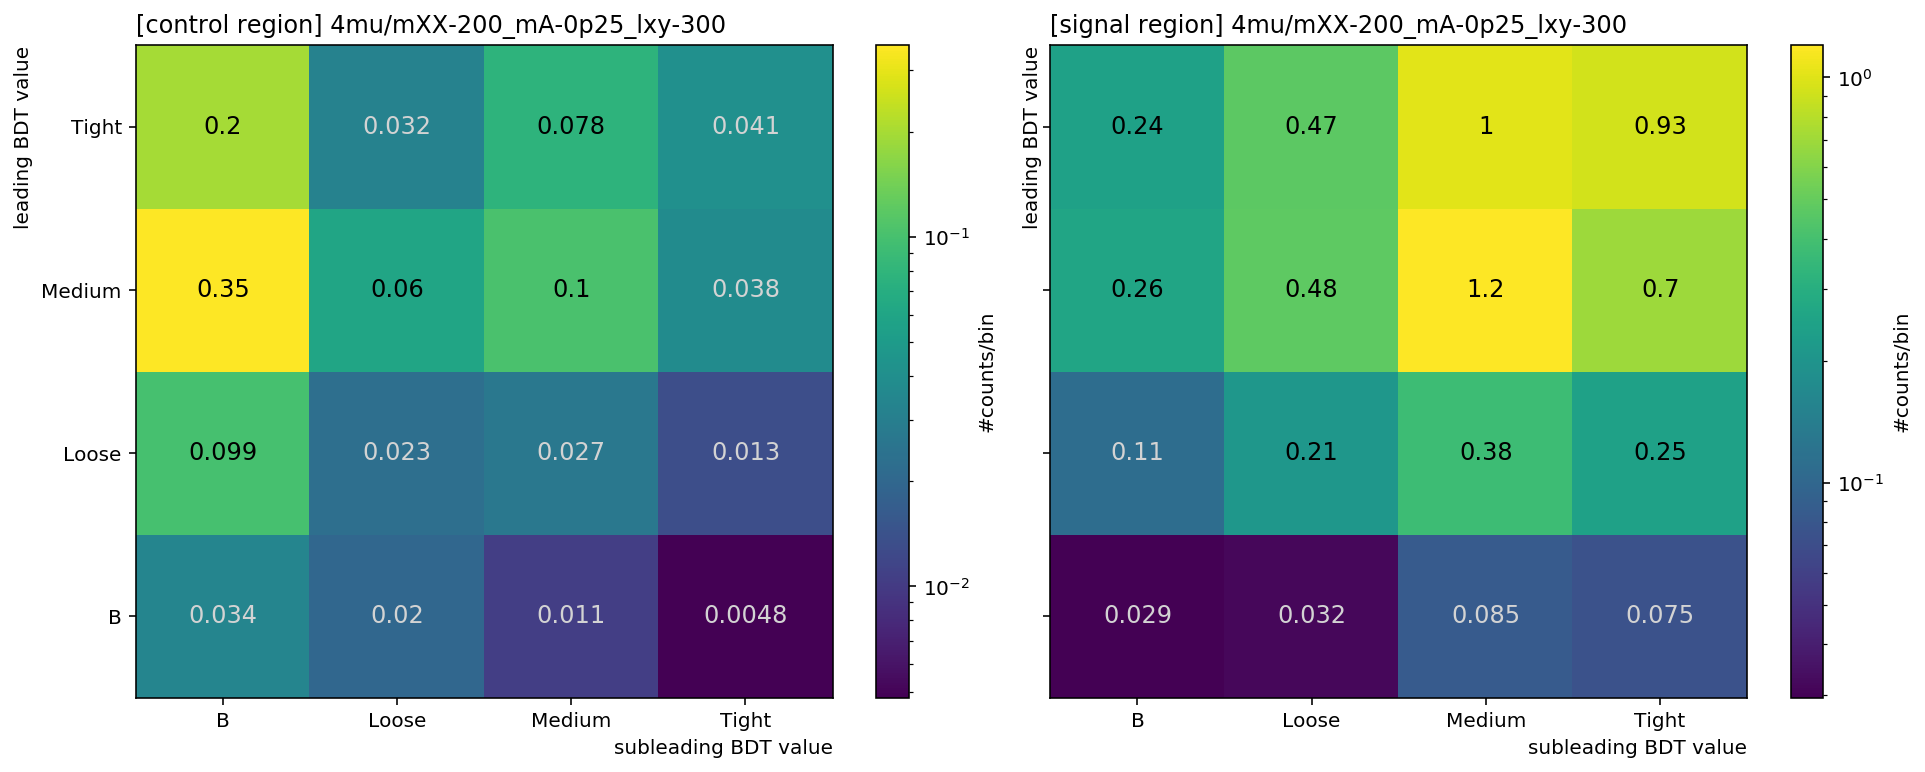

In [68]:
makeplot('4mu/mXX-200_mA-0p25_lxy-300')

### mXX=200 mA=1.2 lxy=300
4mu/mXX-200_mA-1p2_lxy-300

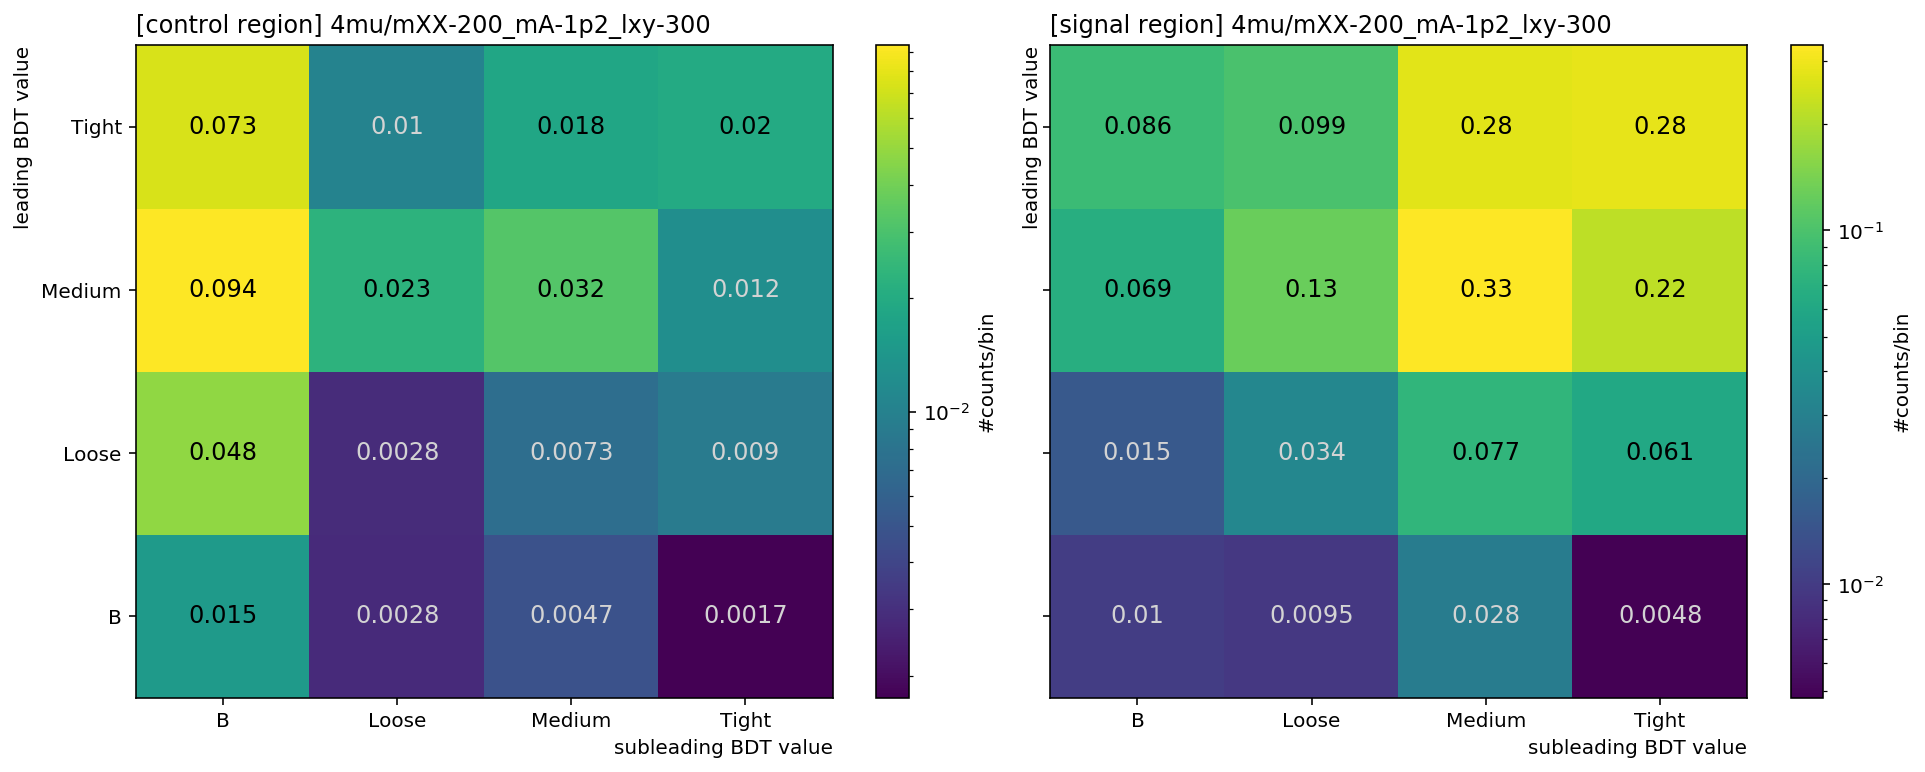

In [69]:
makeplot('4mu/mXX-200_mA-1p2_lxy-300')

### mXX=200 mA=5 lxy=300
4mu/mXX-200_mA-5_lxy-300

In [70]:
makeplot('4mu/mXX-200_mA-5_lxy-300')

### mXX=500 mA=0.25 lxy=300
4mu/mXX-500_mA-0p25_lxy-300

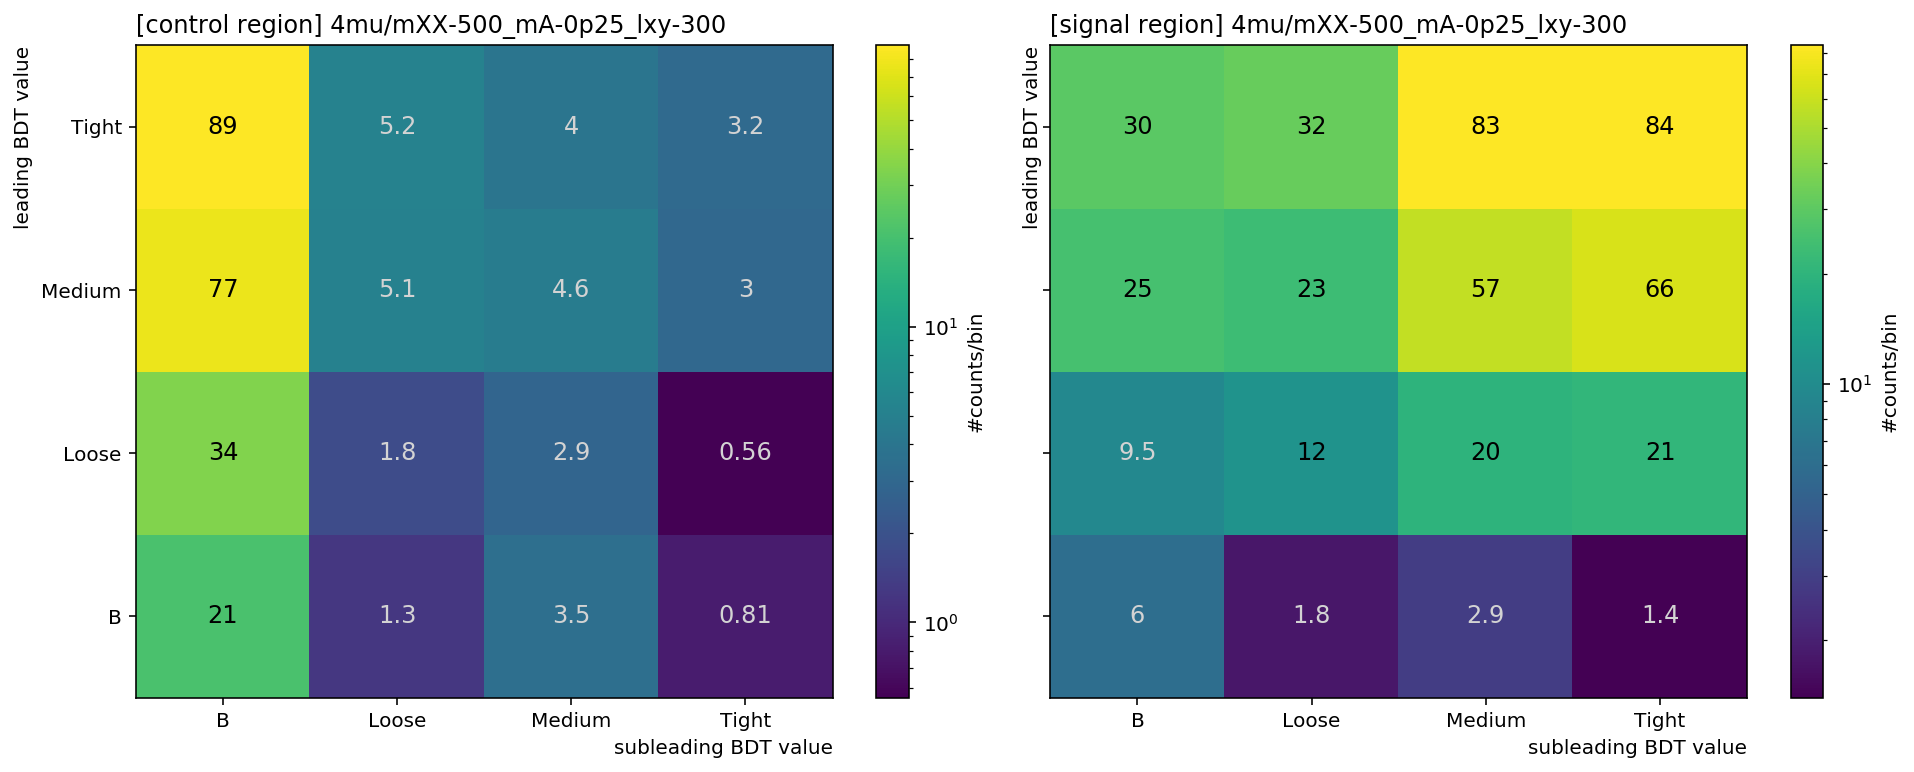

In [72]:
makeplot('4mu/mXX-500_mA-0p25_lxy-300')

### mXX=500 mA=1.2 lxy=300
4mu/mXX-500_mA-1p2_lxy-300

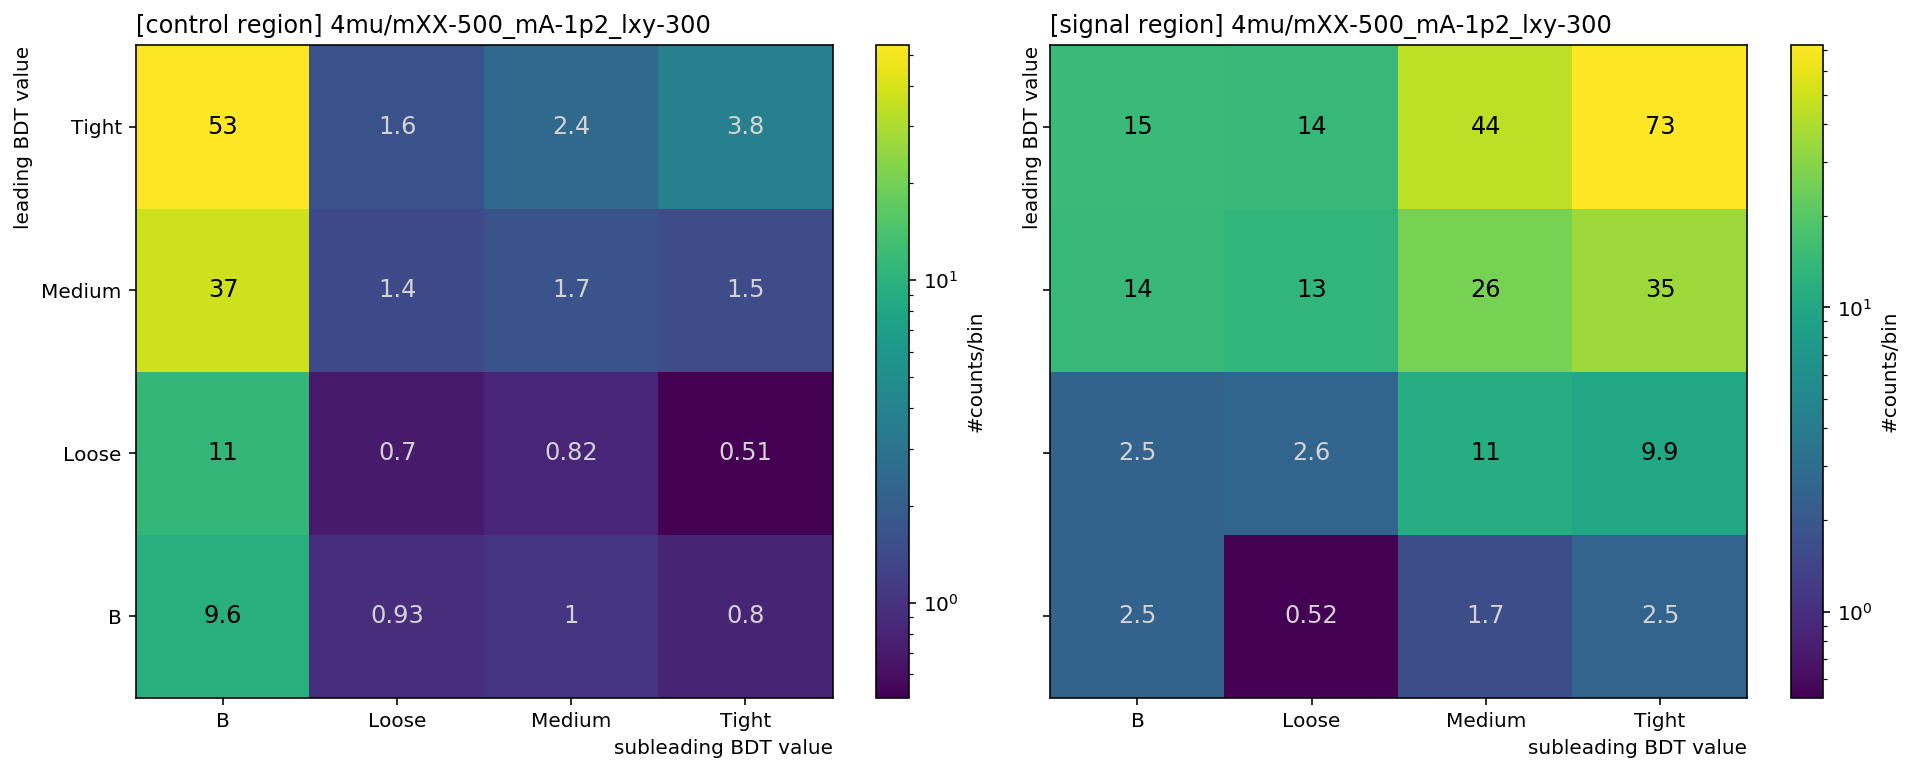

In [73]:
makeplot('4mu/mXX-500_mA-1p2_lxy-300')

### mXX=500 mA=5 lxy=300
4mu/mXX-500_mA-5_lxy-300

In [74]:
makeplot('4mu/mXX-500_mA-5_lxy-300')

### mXX=800 mA=0.25 lxy=300
4mu/mXX-800_mA-0p25_lxy-300

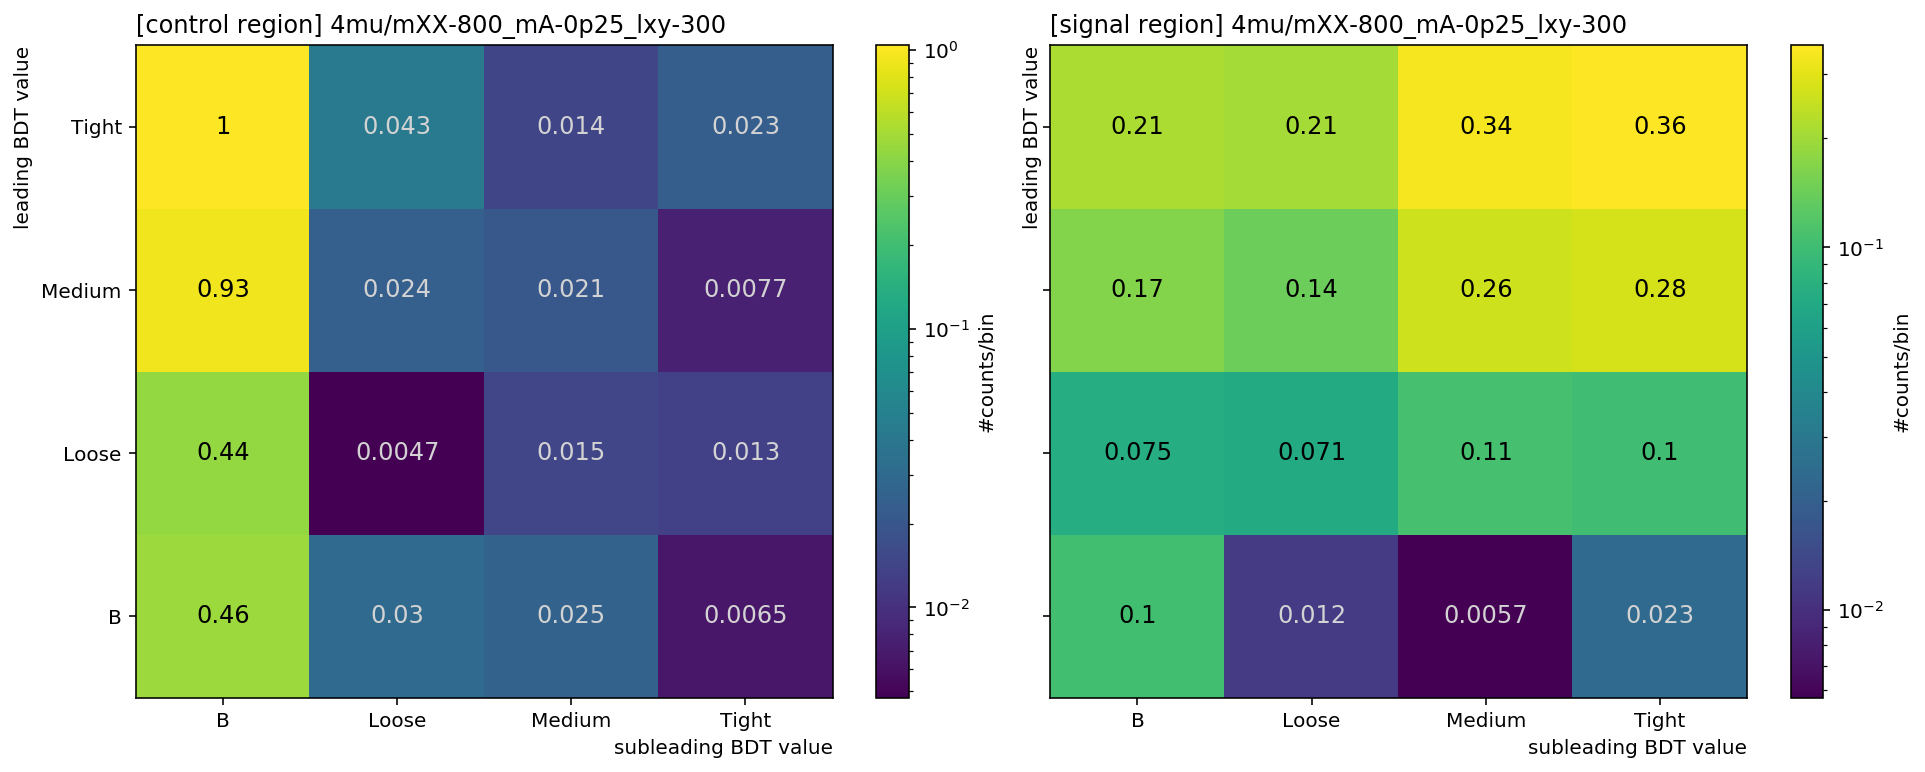

In [75]:
makeplot('4mu/mXX-800_mA-0p25_lxy-300')

### mXX=800 mA=1.2 lxy=300
4mu/mXX-800_mA-1p2_lxy-300

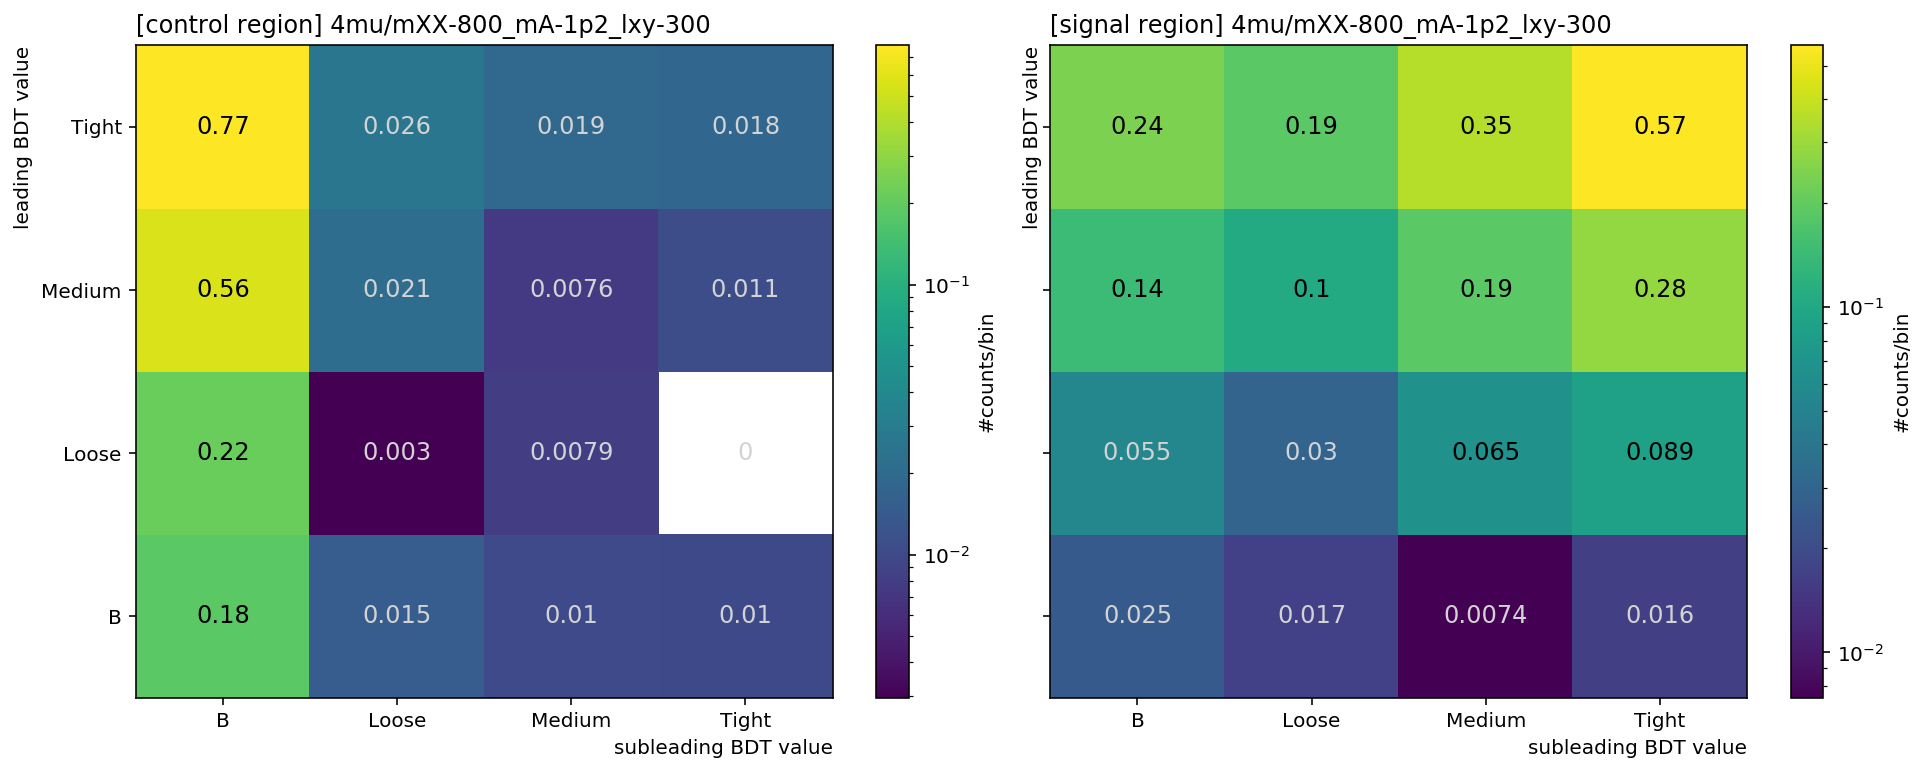

In [76]:
makeplot('4mu/mXX-800_mA-1p2_lxy-300')

### mXX=800 mA=5 lxy=300
4mu/mXX-800_mA-5_lxy-300

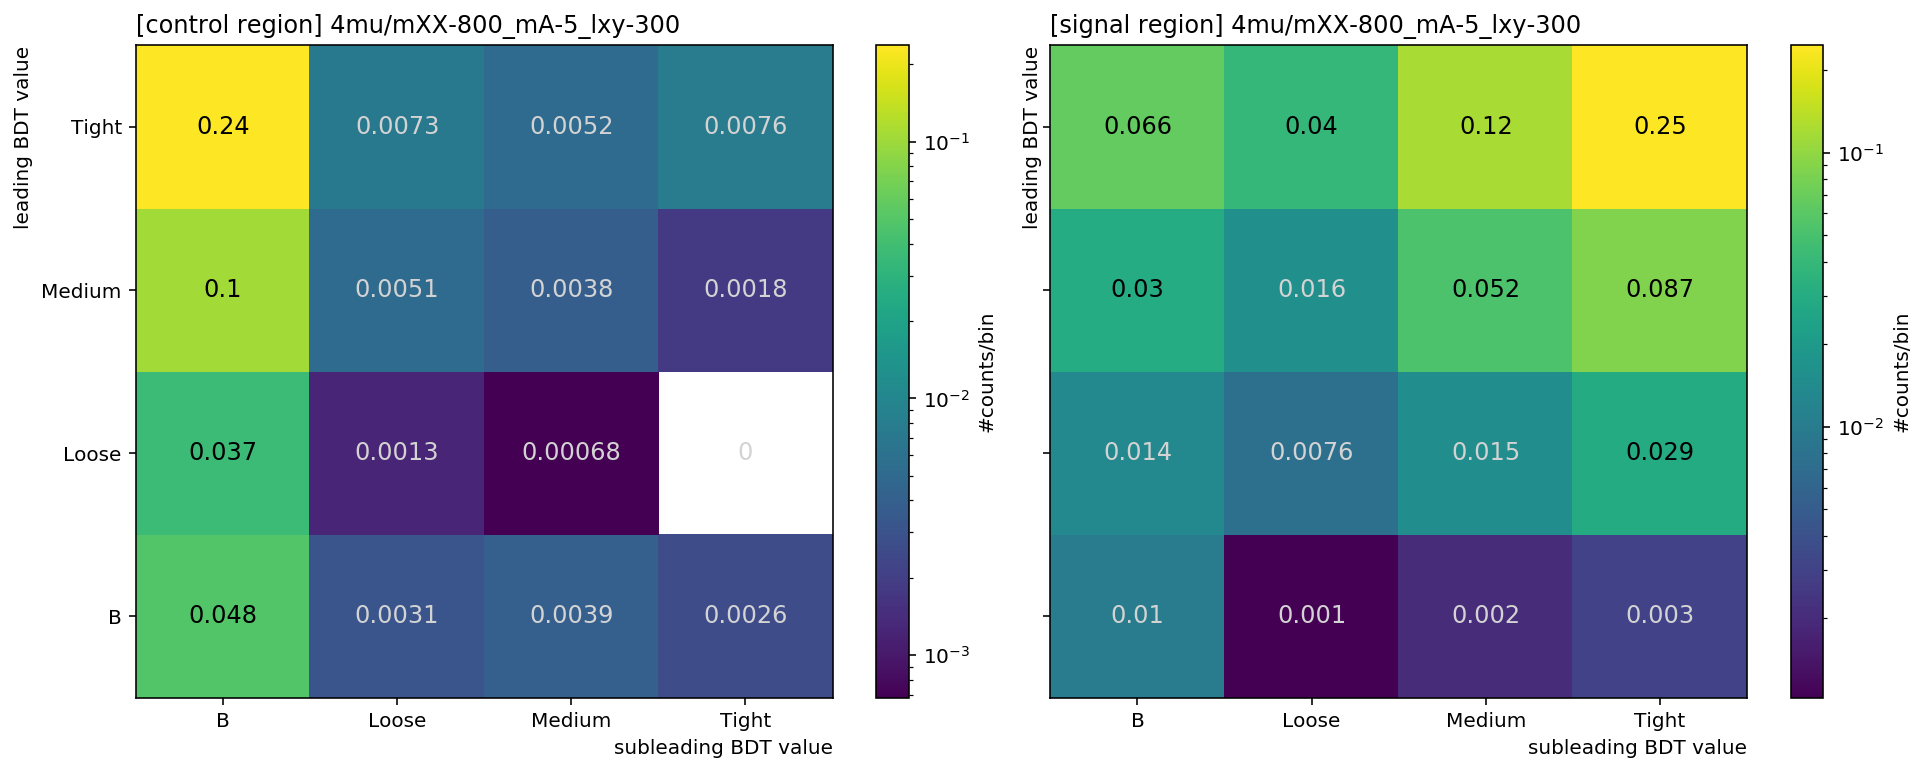

In [77]:
makeplot('4mu/mXX-800_mA-5_lxy-300')

### mXX=1000 mA=0.25 lxy=0.3
4mu/mXX-1000_mA-0p25_lxy-0p3

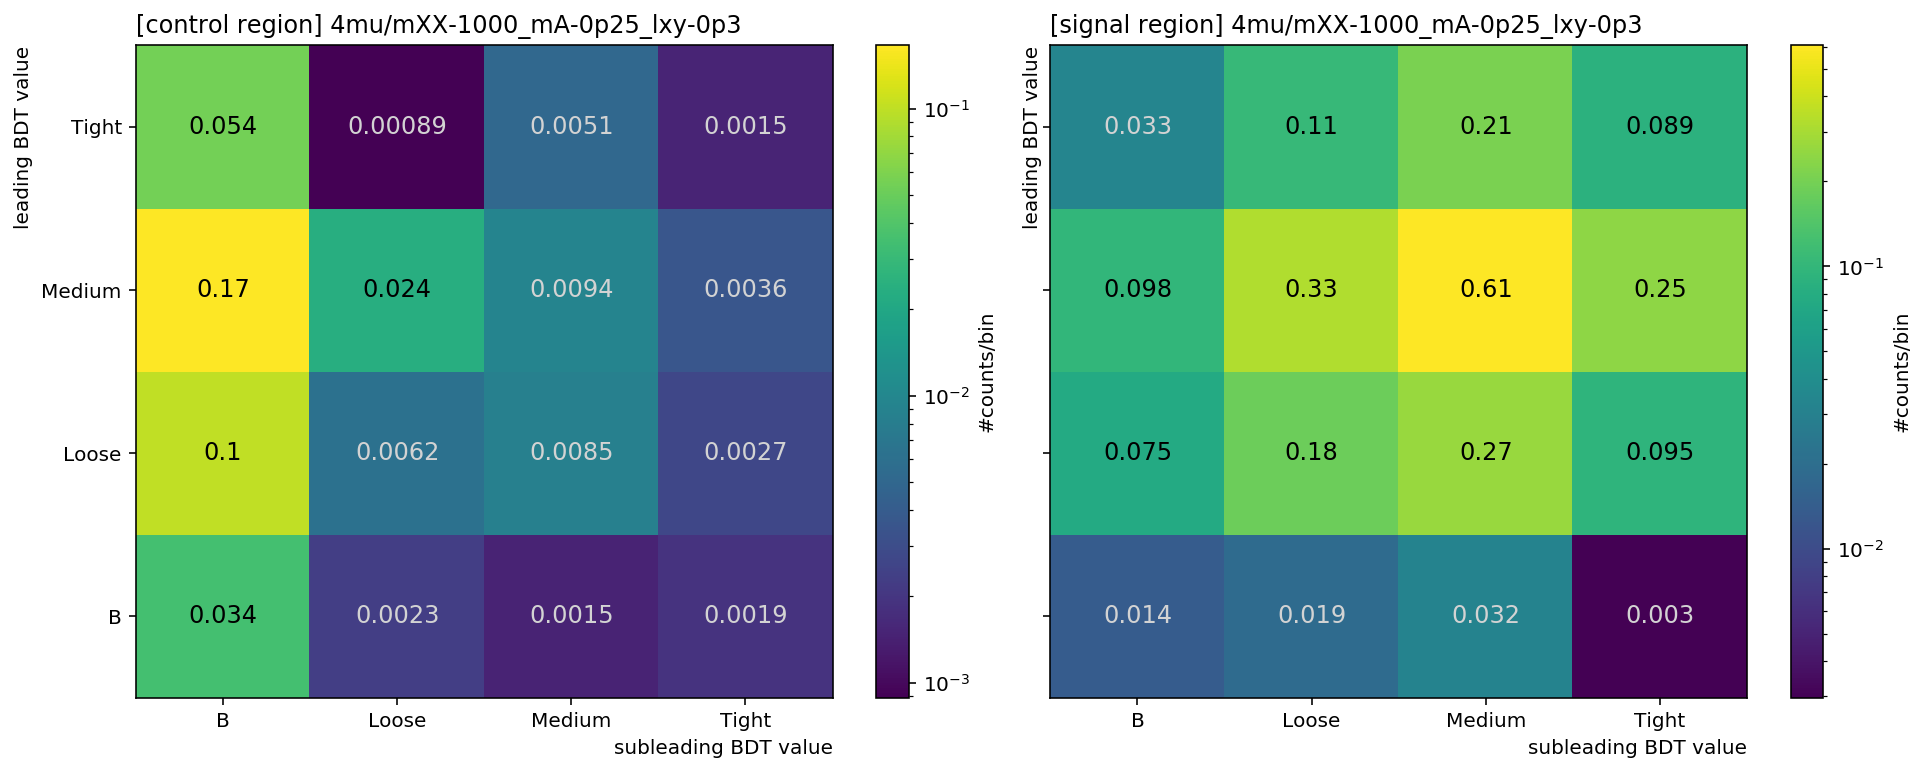

In [78]:
makeplot('4mu/mXX-1000_mA-0p25_lxy-0p3')

### mXX=1000 mA=0.25 lxy=300
4mu/mXX-1000_mA-0p25_lxy-300

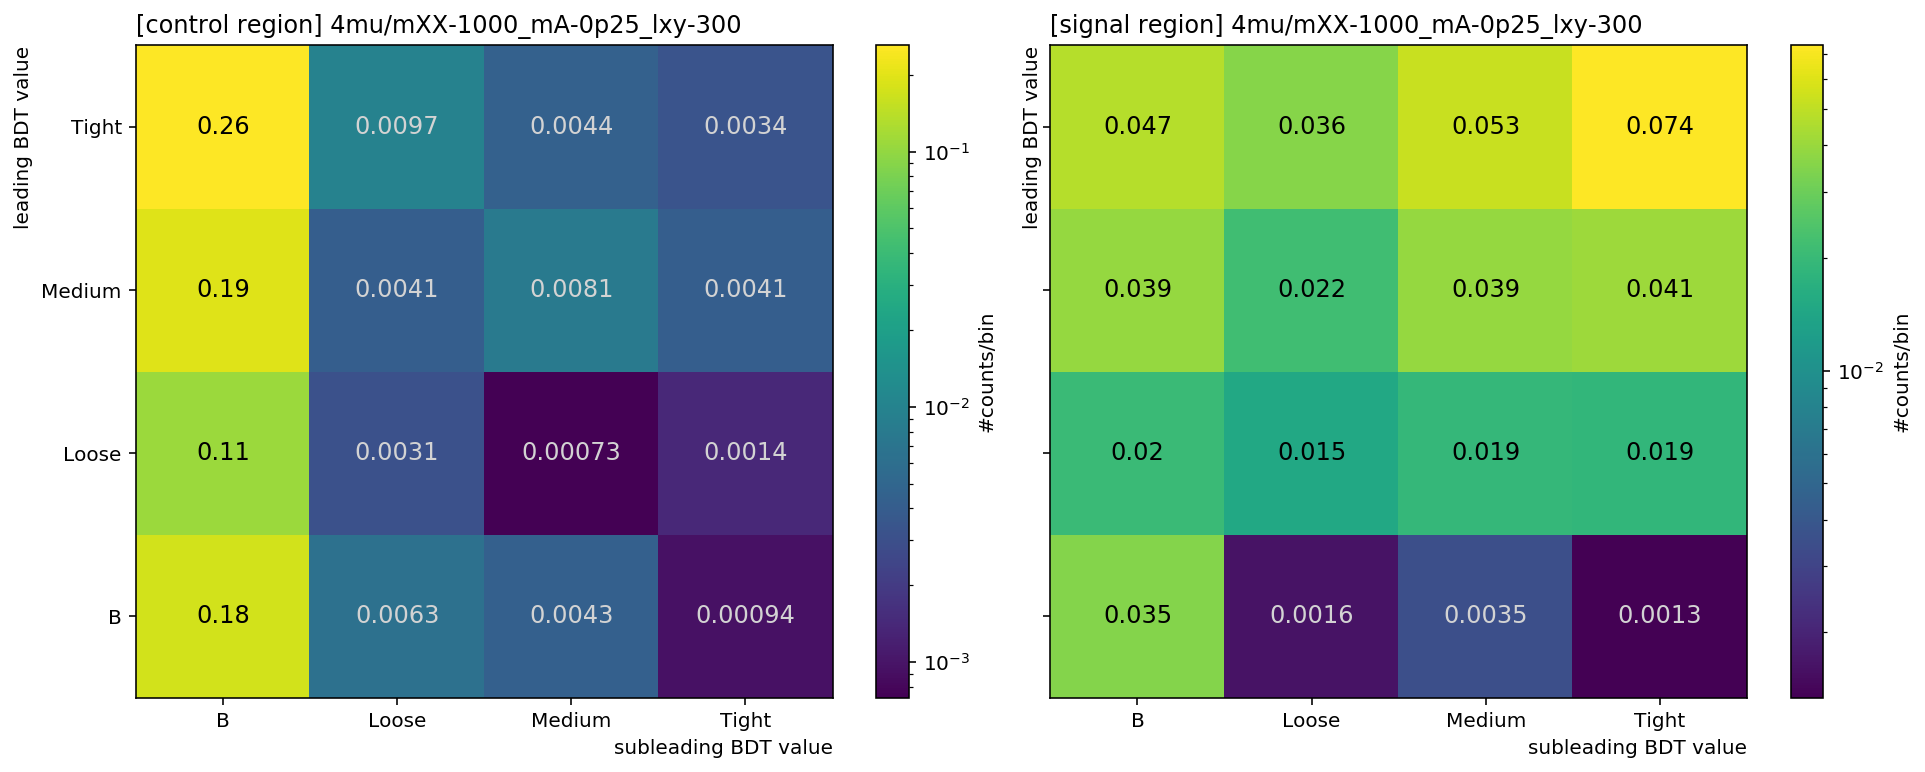

In [79]:
makeplot('4mu/mXX-1000_mA-0p25_lxy-300')

### mXX=1000 mA=1.2 lxy=300
4mu/mXX-1000_mA-1p2_lxy-300

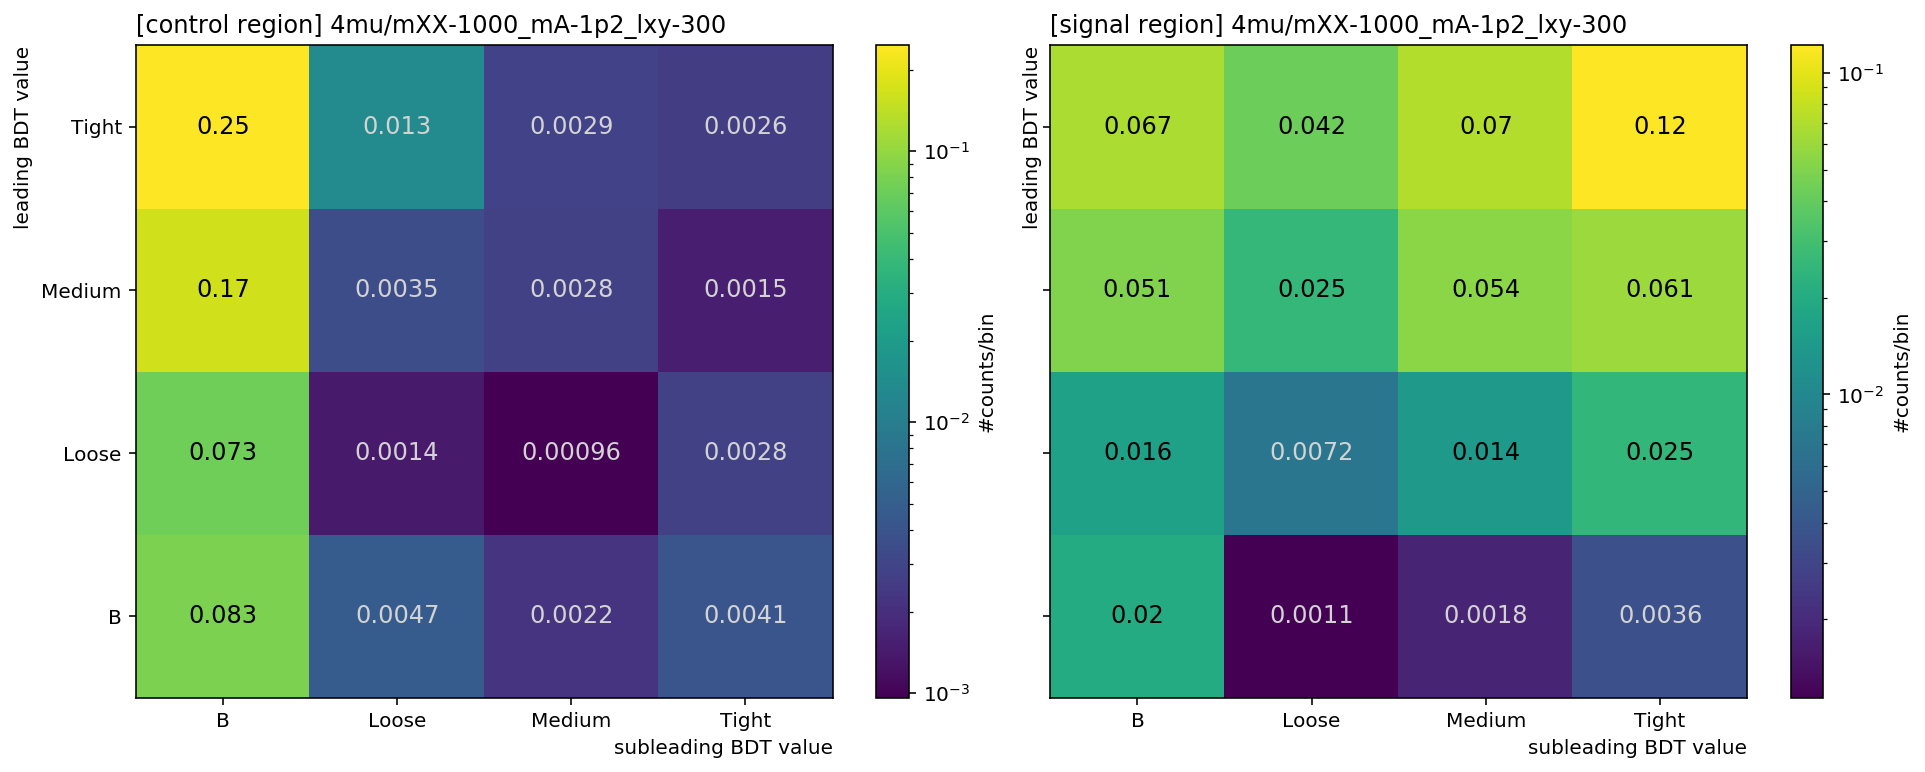

In [80]:
makeplot('4mu/mXX-1000_mA-1p2_lxy-300')

### mXX=1000 mA=5 lxy=300
4mu/mXX-1000_mA-5_lxy-300

In [81]:
makeplot('4mu/mXX-1000_mA-5_lxy-300')

## 2mu2e

### mXX=100 mA=0.25 lxy=300
2mu2e/mXX-100_mA-0p25_lxy-300

In [82]:
makeplot('2mu2e/mXX-100_mA-0p25_lxy-300')

### mXX=100 mA=1.2 lxy=300
2mu2e/mXX-100_mA-1p2_lxy-300

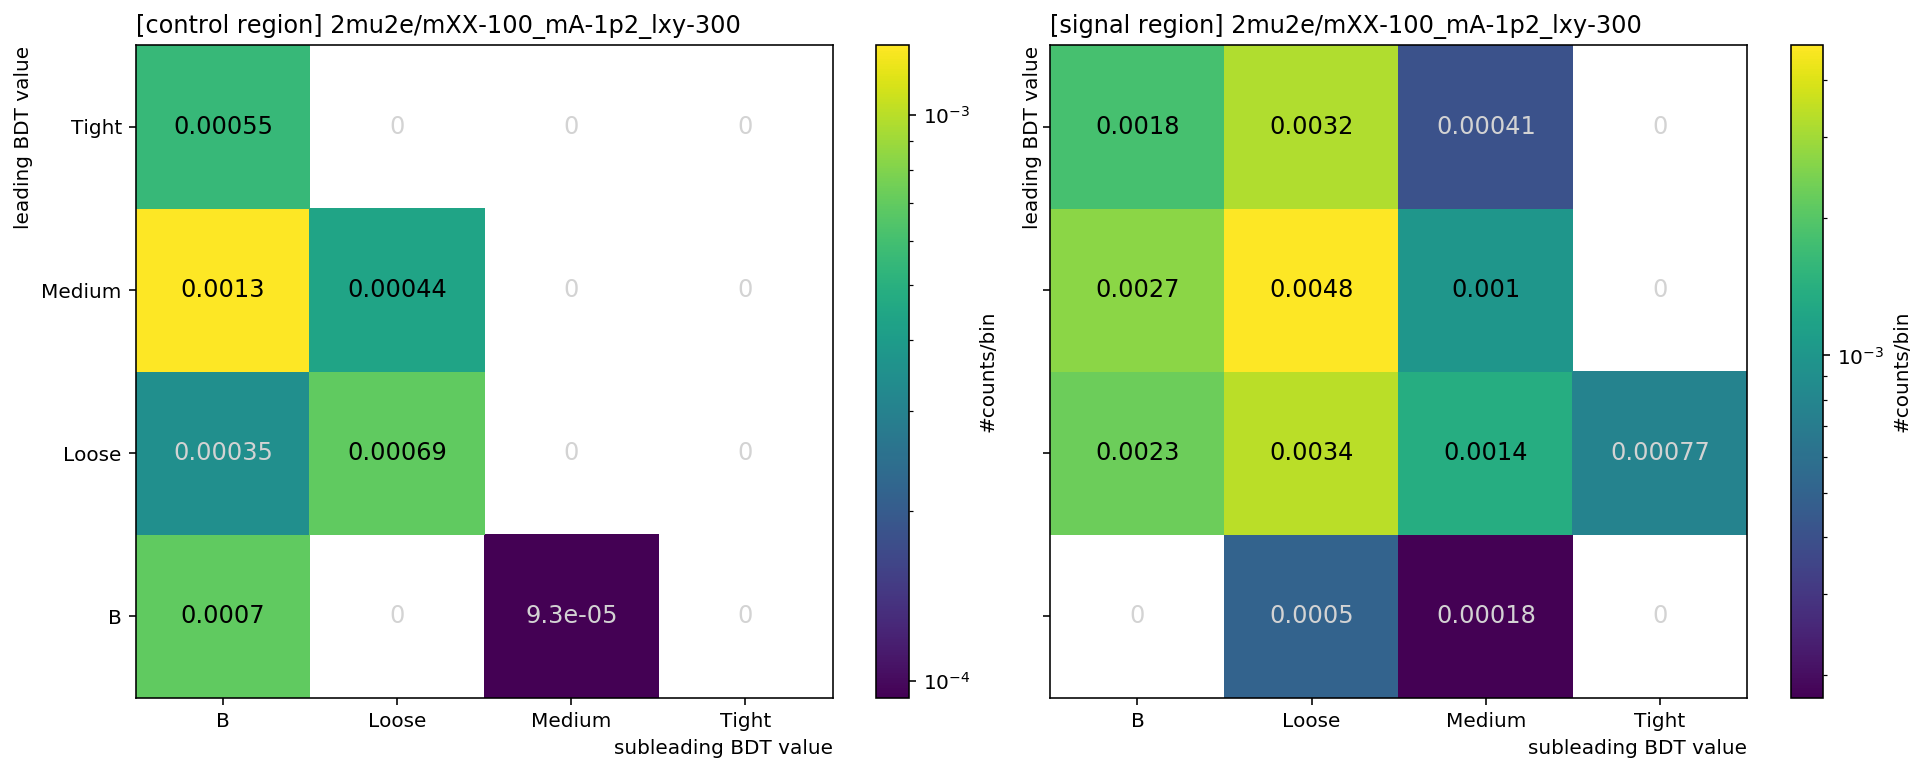

In [83]:
makeplot('2mu2e/mXX-100_mA-1p2_lxy-300')

### mXX=100 mA=5 lxy=300
2mu2e/mXX-100_mA-5_lxy-300

In [84]:
makeplot('2mu2e/mXX-100_mA-5_lxy-300')

### mXX=100 mA=5 lxy=0.3
2mu2e/mXX-100_mA-5_lxy-0p3

In [85]:
makeplot('2mu2e/mXX-100_mA-5_lxy-0p3')

### mXX=150 mA=0.25 lxy=300
2mu2e/mXX-150_mA-0p25_lxy-300

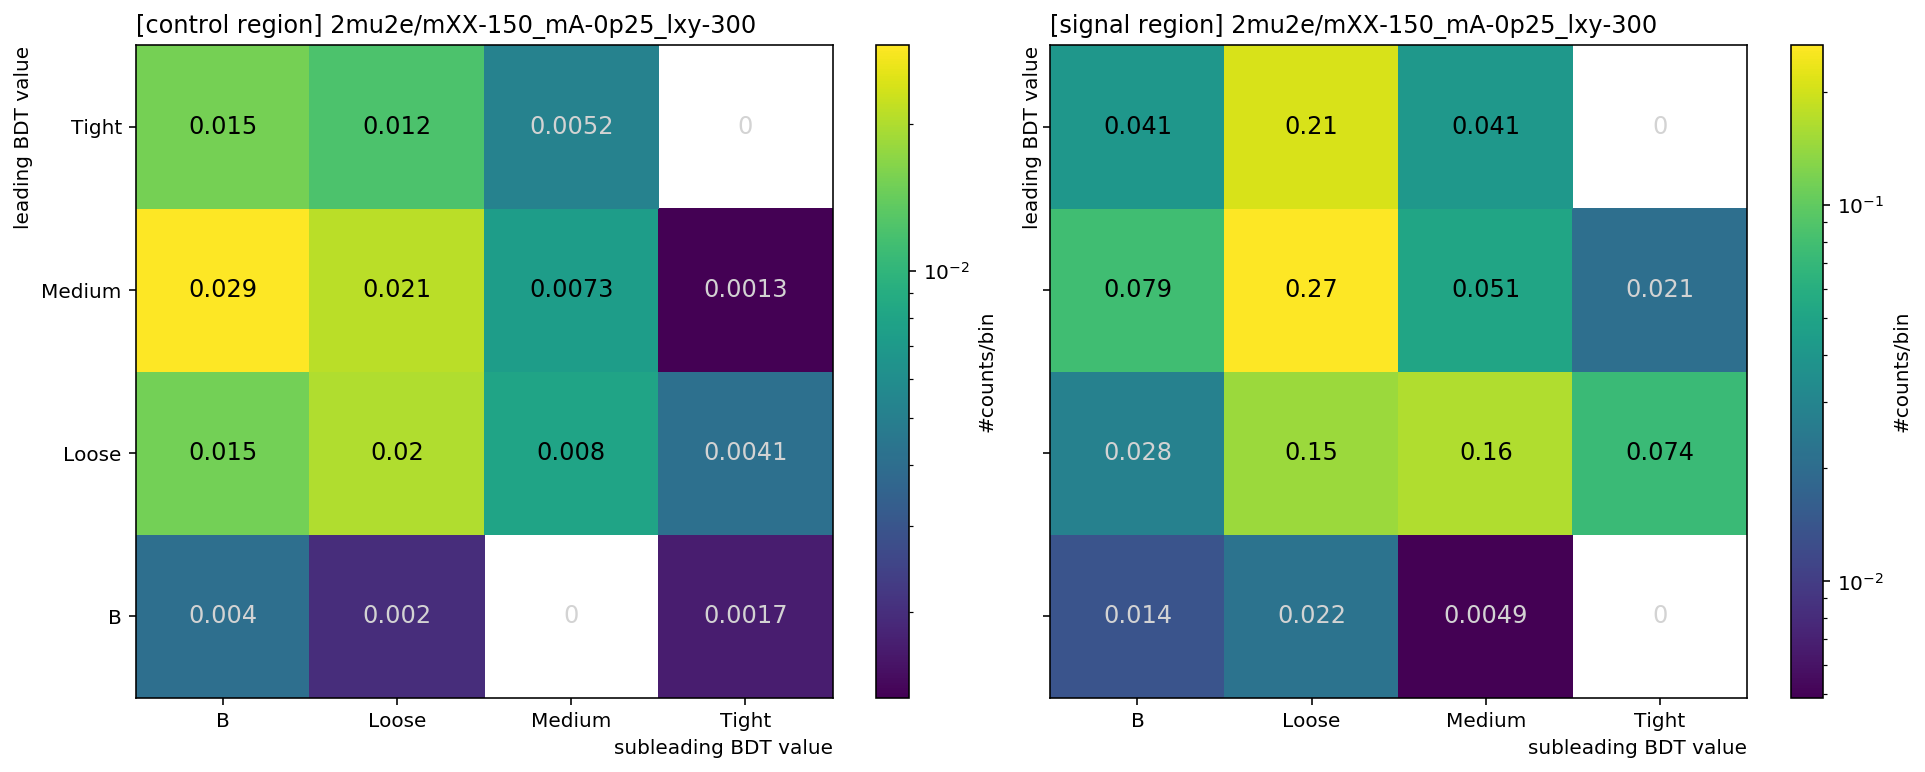

In [86]:
makeplot('2mu2e/mXX-150_mA-0p25_lxy-300')

### mXX=150 mA=1.2 lxy=300
2mu2e/mXX-150_mA-1p2_lxy-300

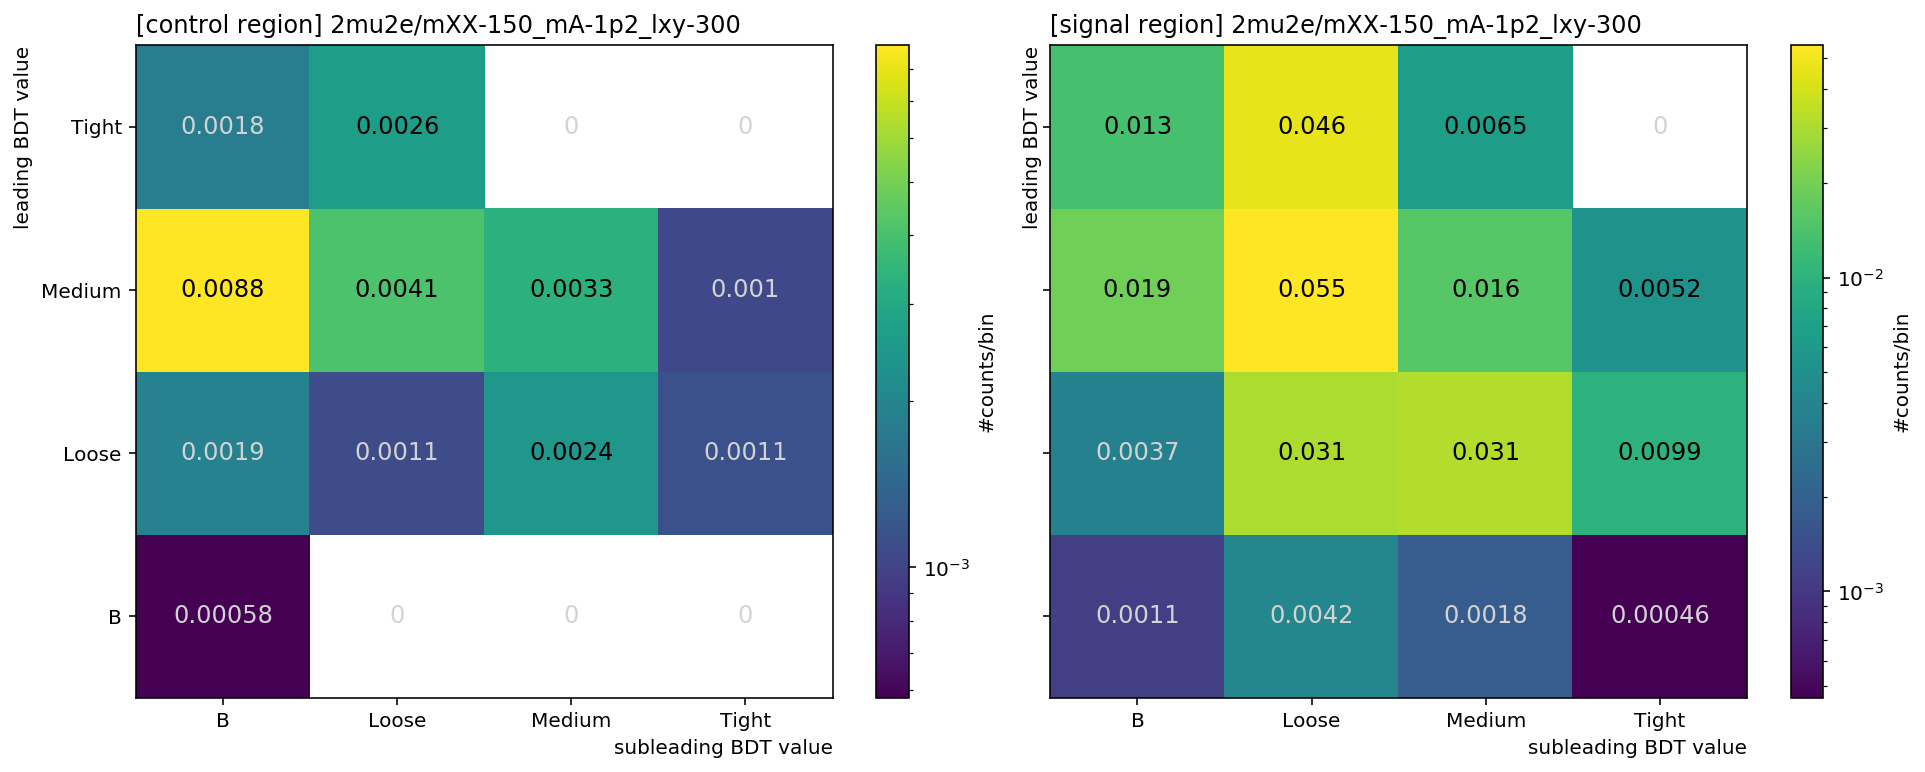

In [87]:
makeplot('2mu2e/mXX-150_mA-1p2_lxy-300')

### mXX=150 mA=5 lxy=300
2mu2e/mXX-150_mA-5_lxy-300

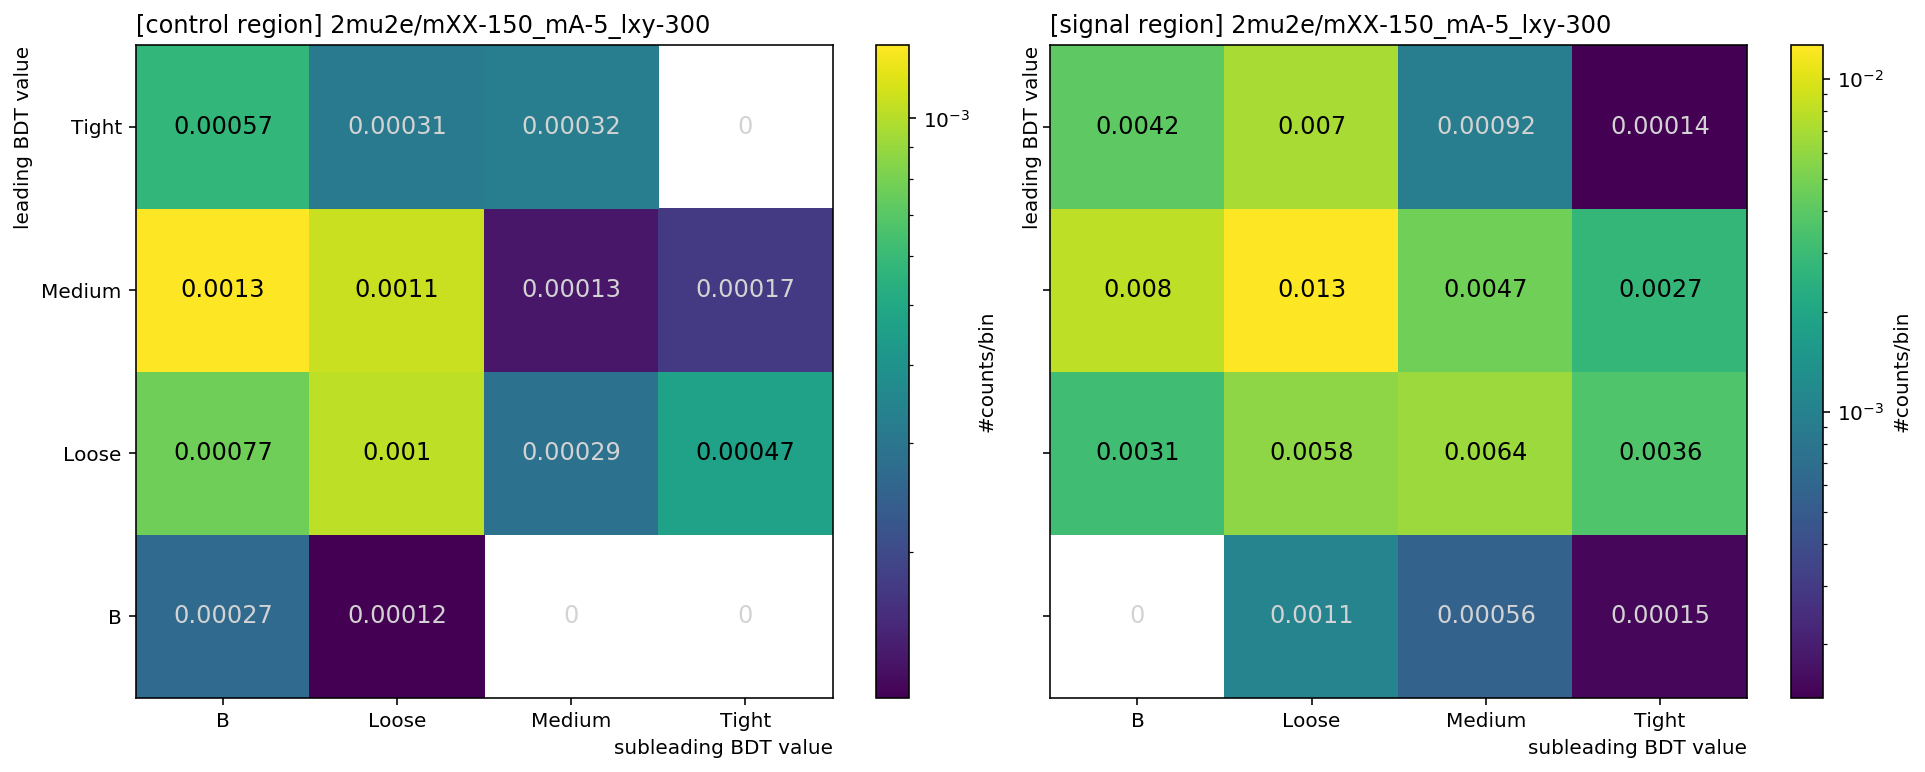

In [88]:
makeplot('2mu2e/mXX-150_mA-5_lxy-300')

### mXX=200 mA=0.25 lxy=300
2mu2e/mXX-200_mA-0p25_lxy-300

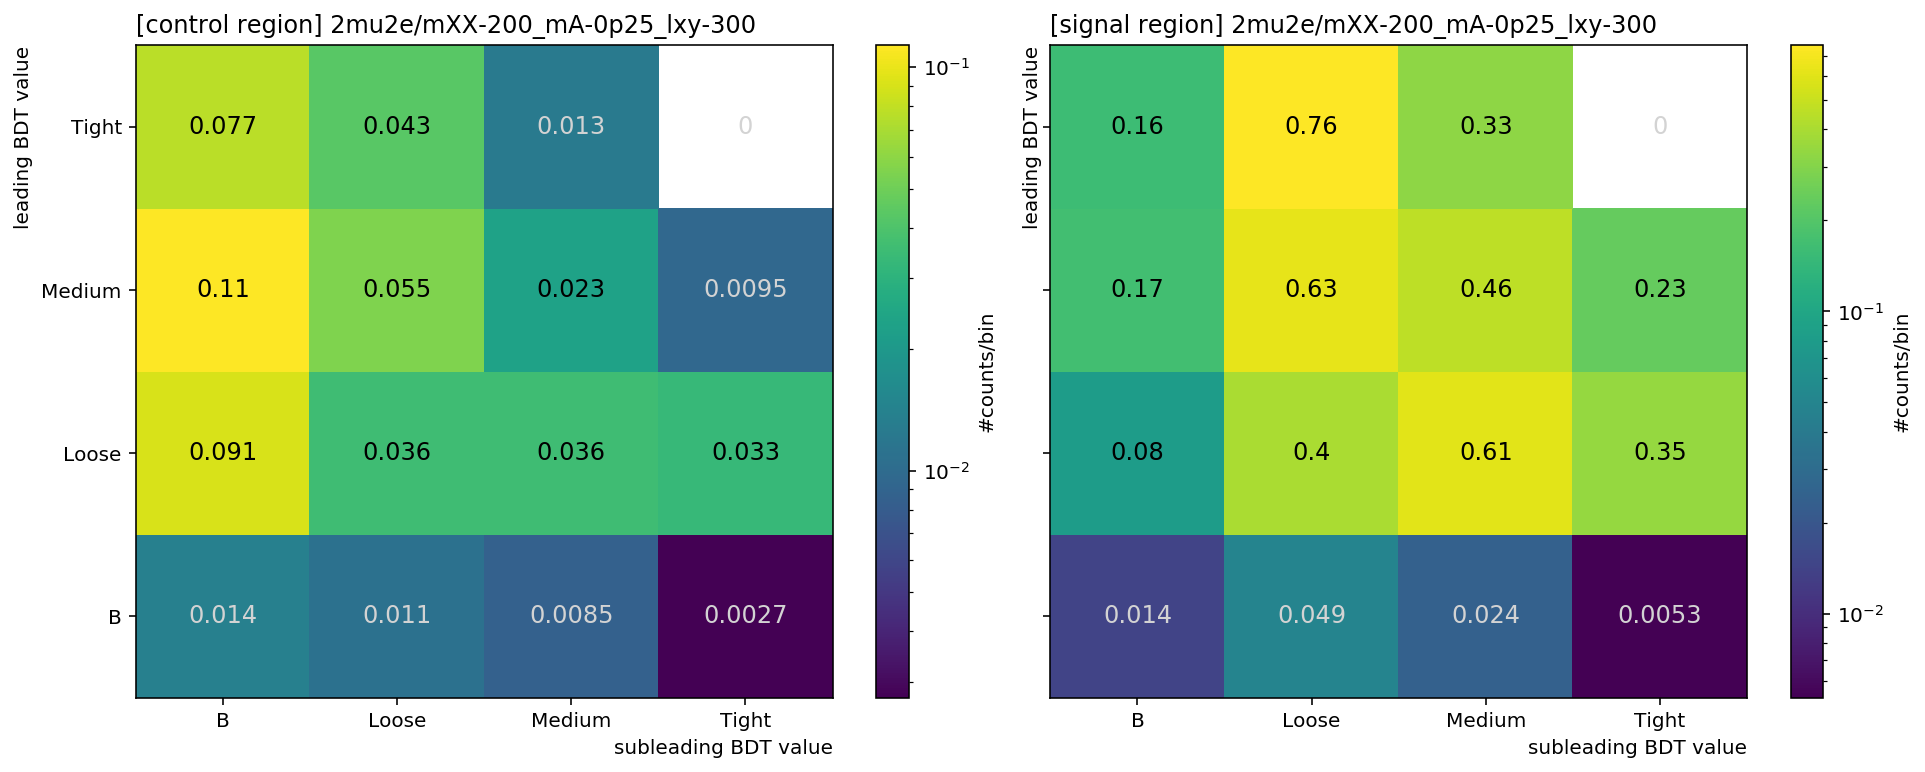

In [89]:
makeplot('2mu2e/mXX-200_mA-0p25_lxy-300')

### mXX=200 mA=1.2 lxy=300
2mu2e/mXX-200_mA-1p2_lxy-300

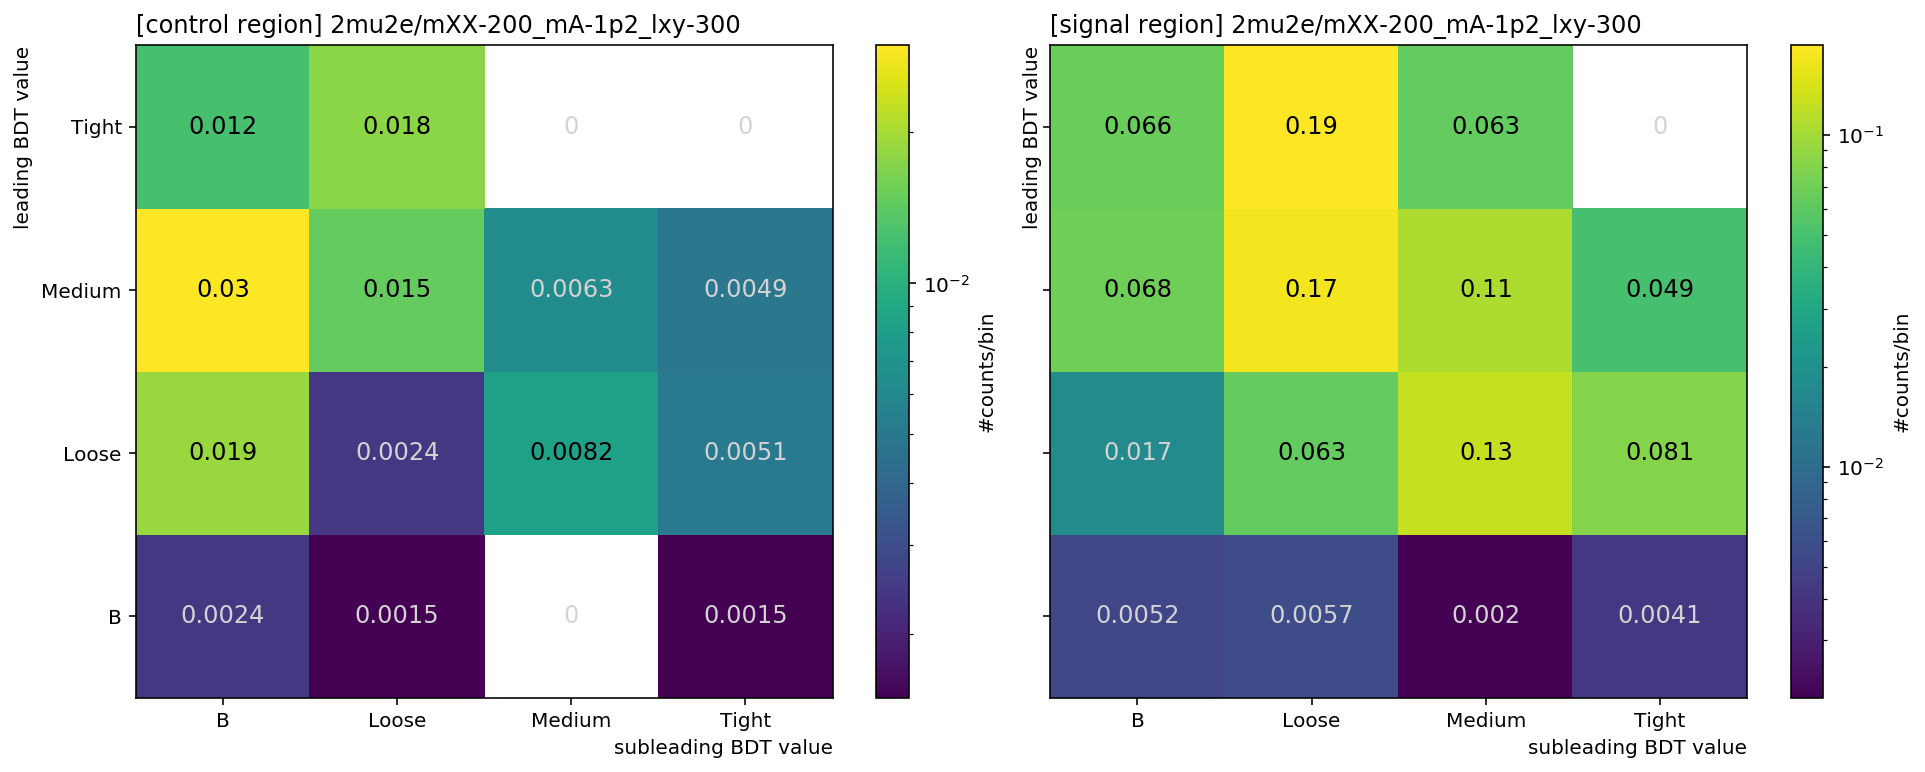

In [90]:
makeplot('2mu2e/mXX-200_mA-1p2_lxy-300')

### mXX=200 mA=5 lxy=300
2mu2e/mXX-200_mA-5_lxy-300

In [91]:
makeplot('2mu2e/mXX-200_mA-5_lxy-300')

### mXX=500 mA=0.25 lxy=300
2mu2e/mXX-500_mA-0p25_lxy-300

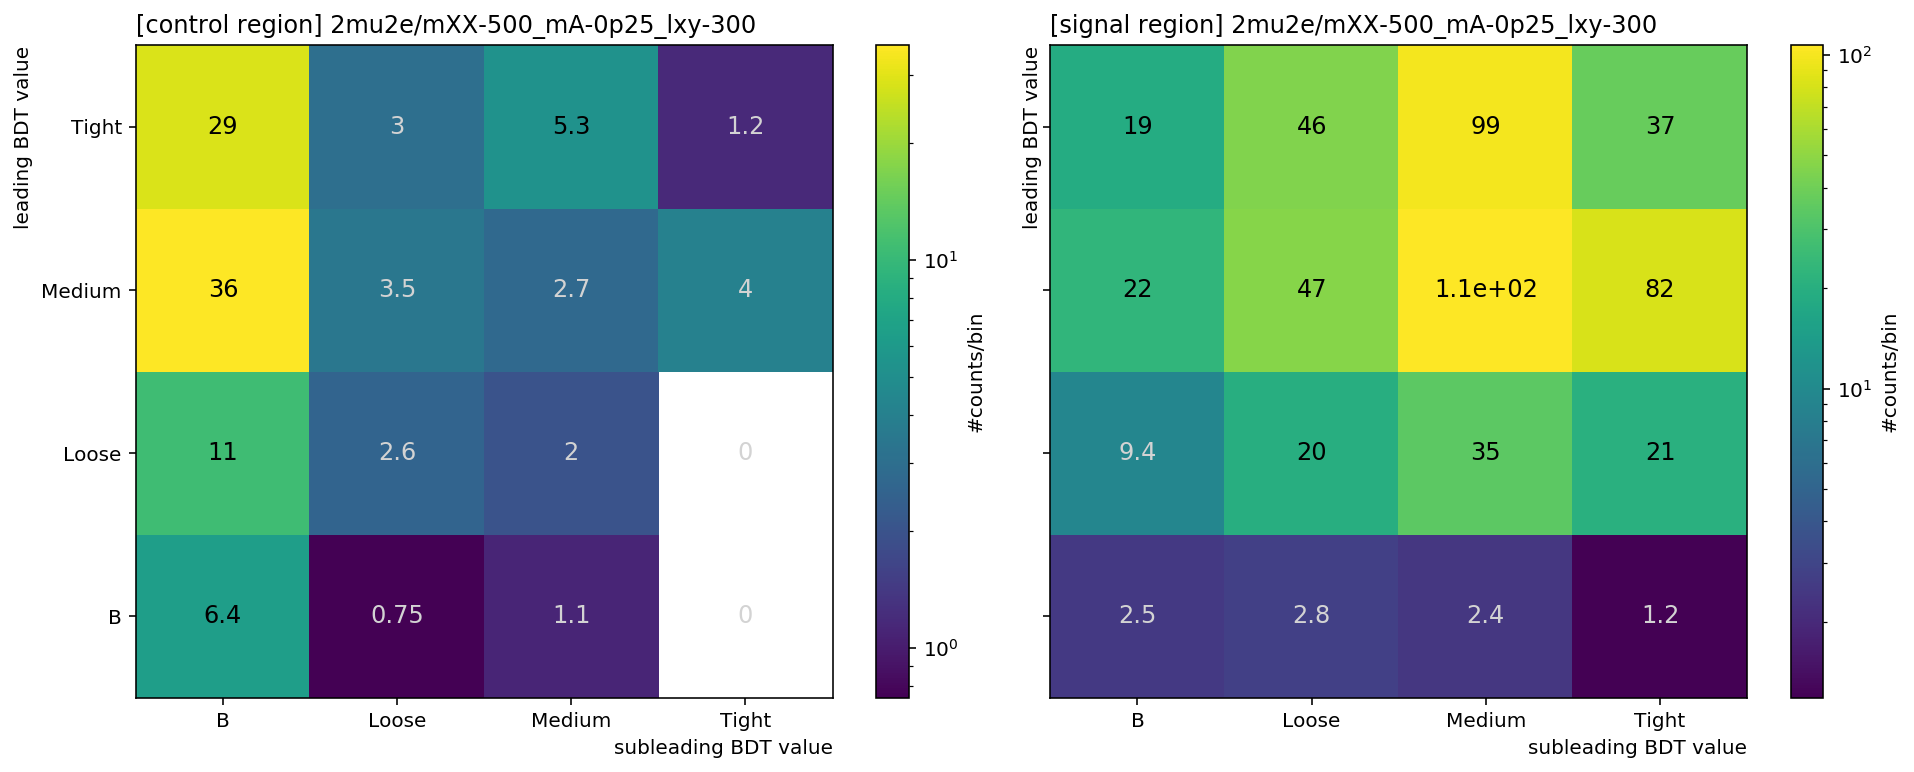

In [92]:
makeplot('2mu2e/mXX-500_mA-0p25_lxy-300')

### mXX=500 mA=1.2 lxy=300
2mu2e/mXX-500_mA-1p2_lxy-300

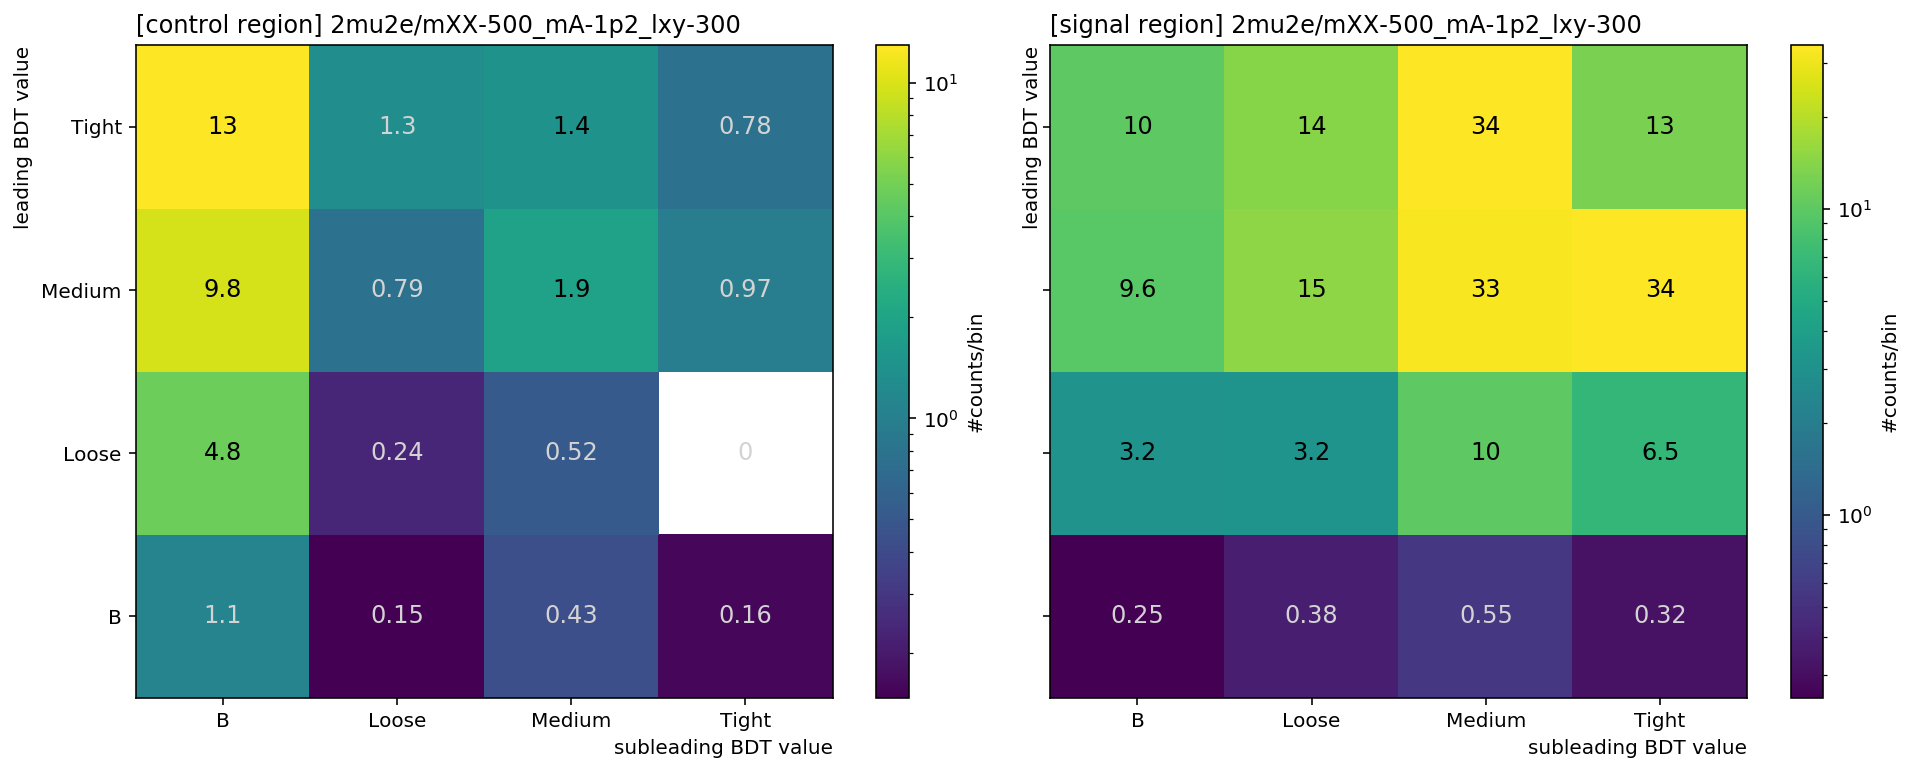

In [93]:
makeplot('2mu2e/mXX-500_mA-1p2_lxy-300')

### mXX=500 mA=5 lxy=300
2mu2e/mXX-500_mA-5_lxy-300

In [94]:
makeplot('2mu2e/mXX-500_mA-5_lxy-300')

### mXX=800 mA=0.25 lxy=300
2mu2e/mXX-800_mA-0p25_lxy-300

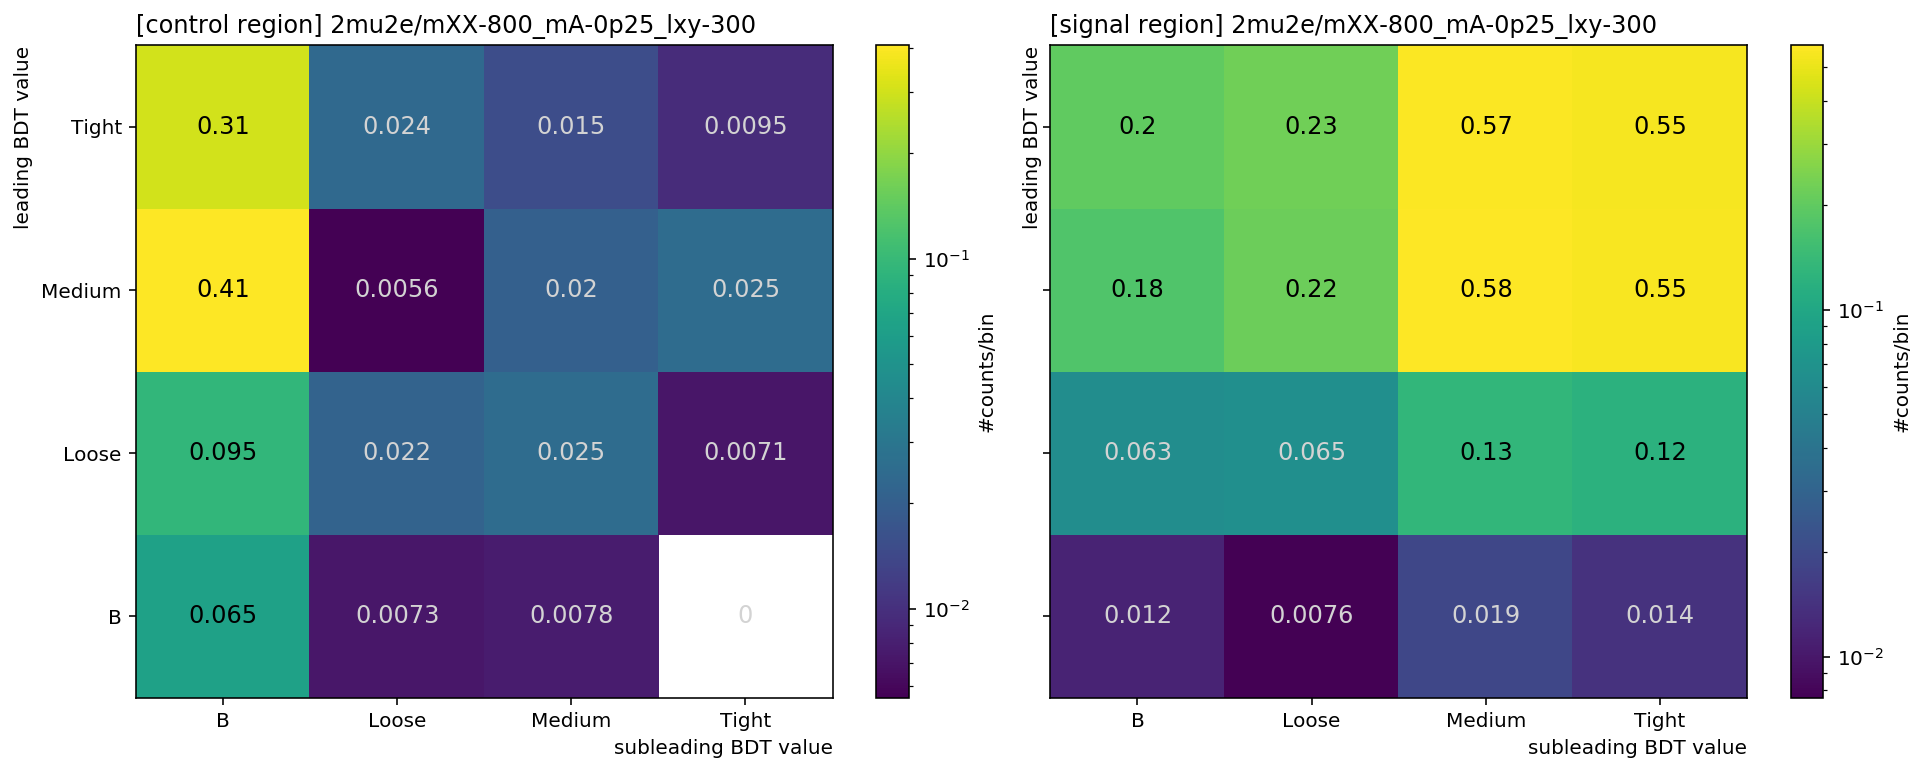

In [95]:
makeplot('2mu2e/mXX-800_mA-0p25_lxy-300')

### mXX=800 mA=1.2 lxy=300
2mu2e/mXX-800_mA-1p2_lxy-300

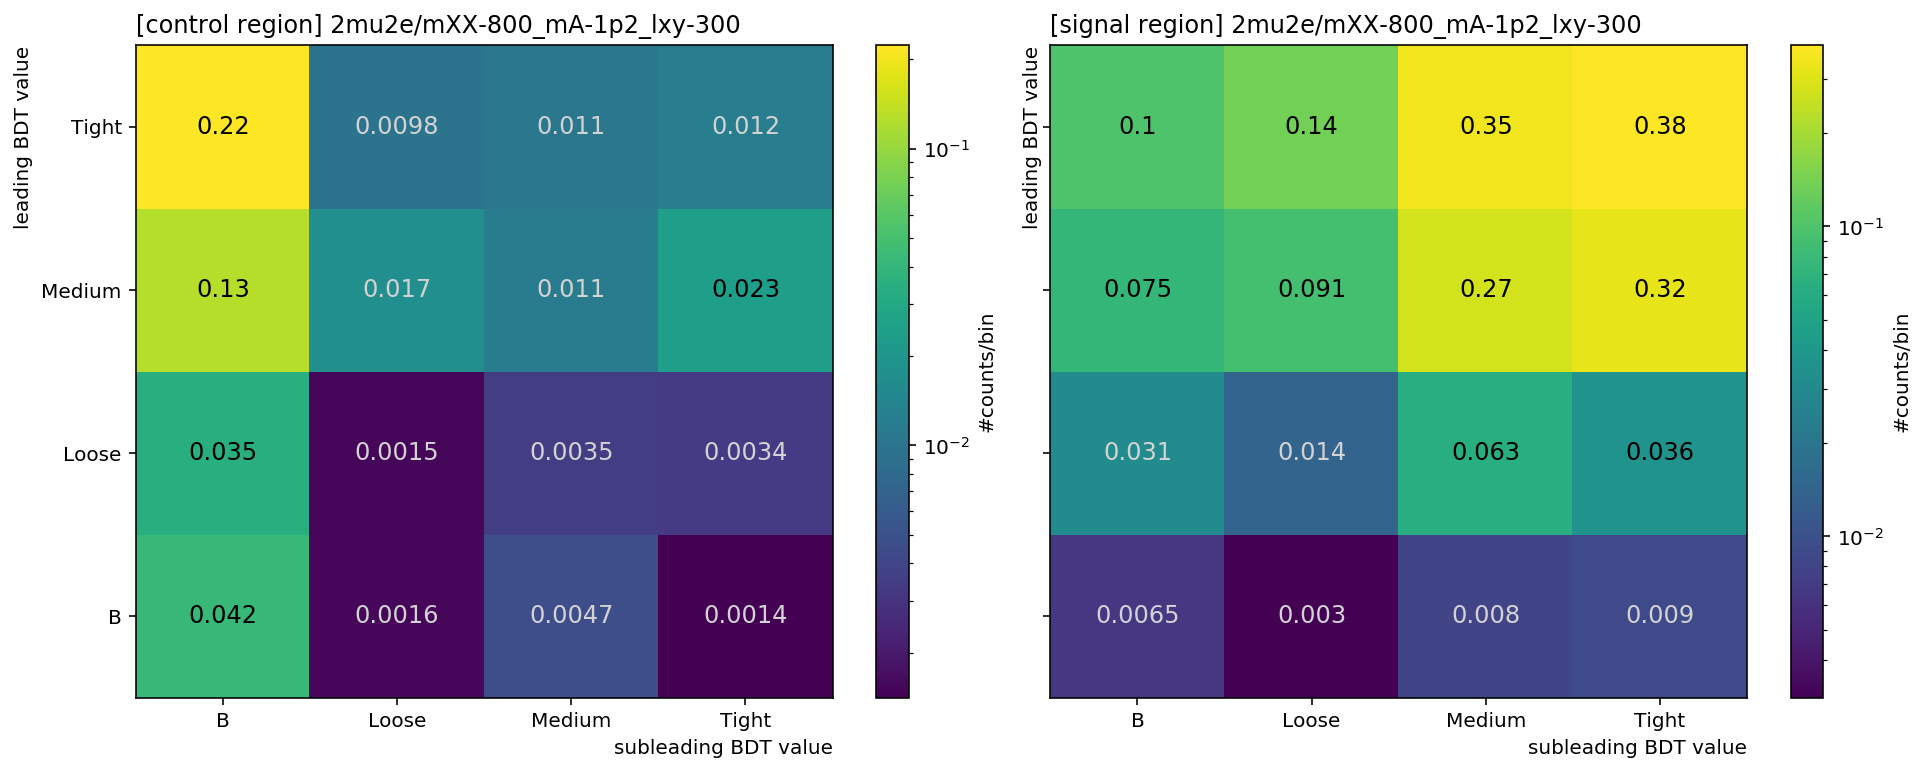

In [96]:
makeplot('2mu2e/mXX-800_mA-1p2_lxy-300')

### mXX=800 mA=5 lxy=300
2mu2e/mXX-800_mA-5_lxy-300

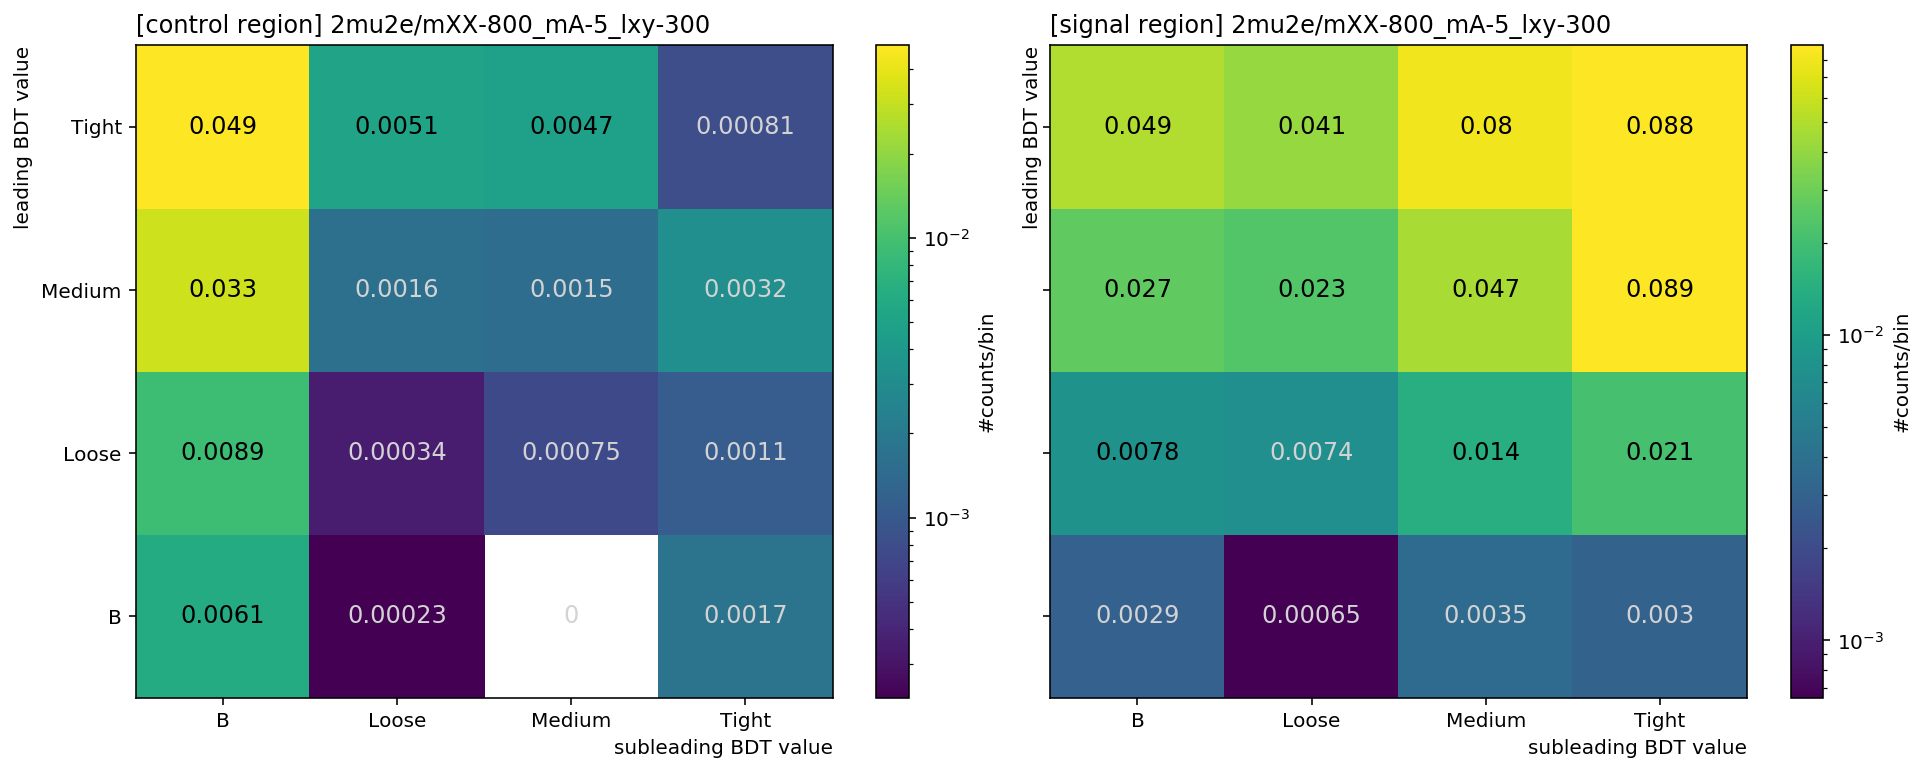

In [97]:
makeplot('2mu2e/mXX-800_mA-5_lxy-300')

### mXX=1000 mA=0.25 lxy=0.3
2mu2e/mXX-1000_mA-0p25_lxy-0p3

In [98]:
makeplot('2mu2e/mXX-1000_mA-0p25_lxy-0p3')

### mXX=1000 mA=0.25 lxy=300
2mu2e/mXX-1000_mA-0p25_lxy-300

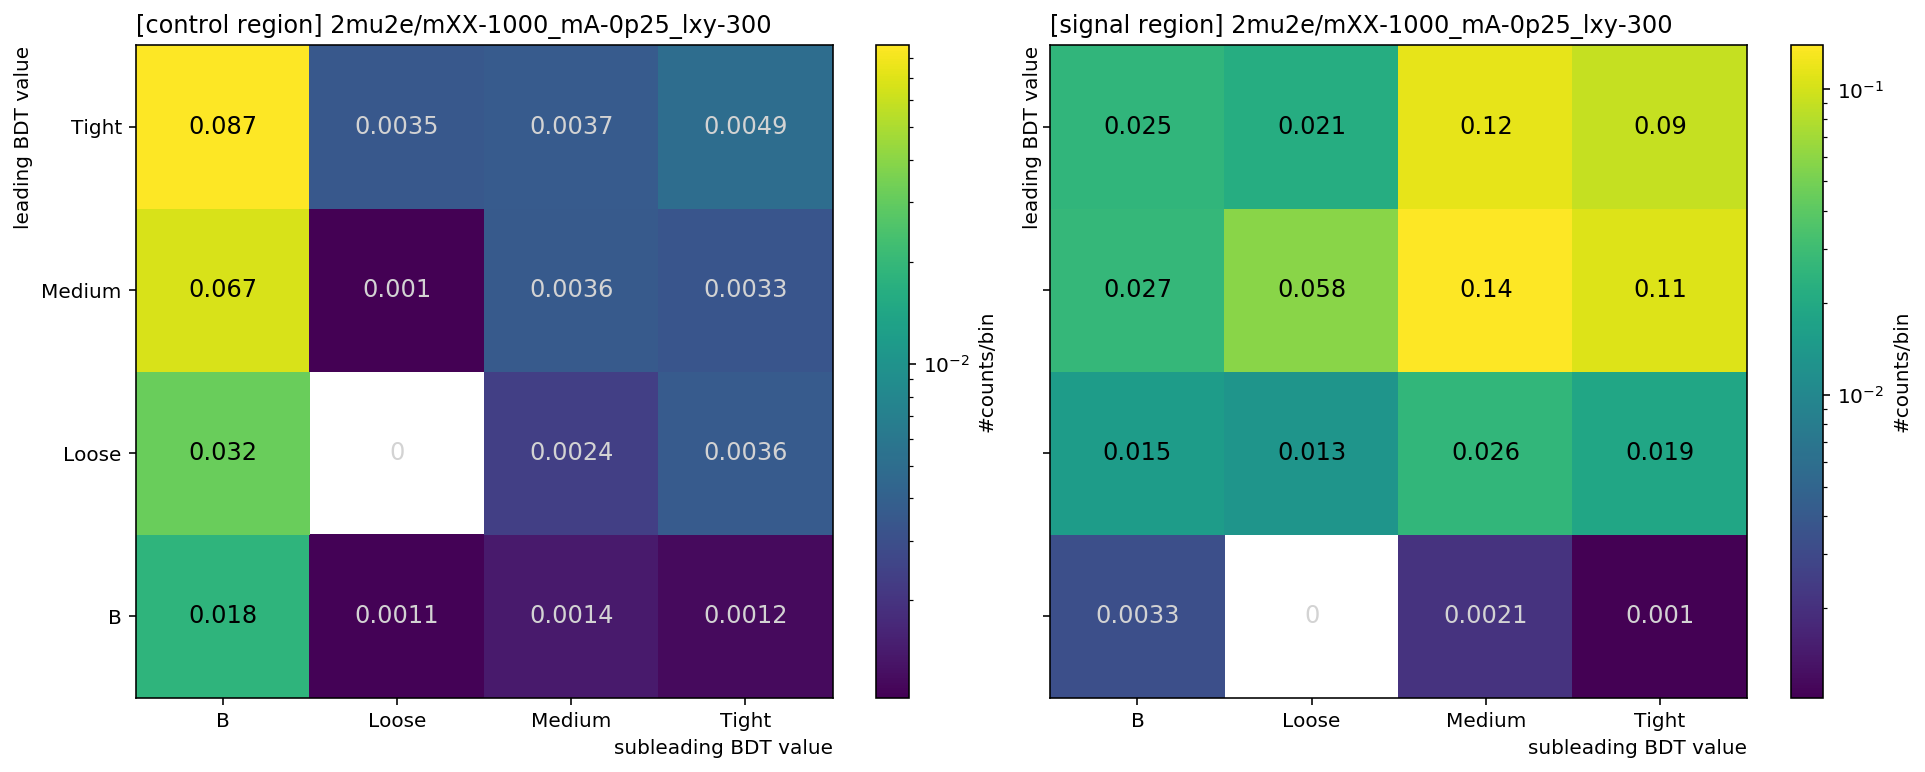

In [99]:
makeplot('2mu2e/mXX-1000_mA-0p25_lxy-300')

### mXX=1000 mA=1.2 lxy=300
2mu2e/mXX-1000_mA-1p2_lxy-300

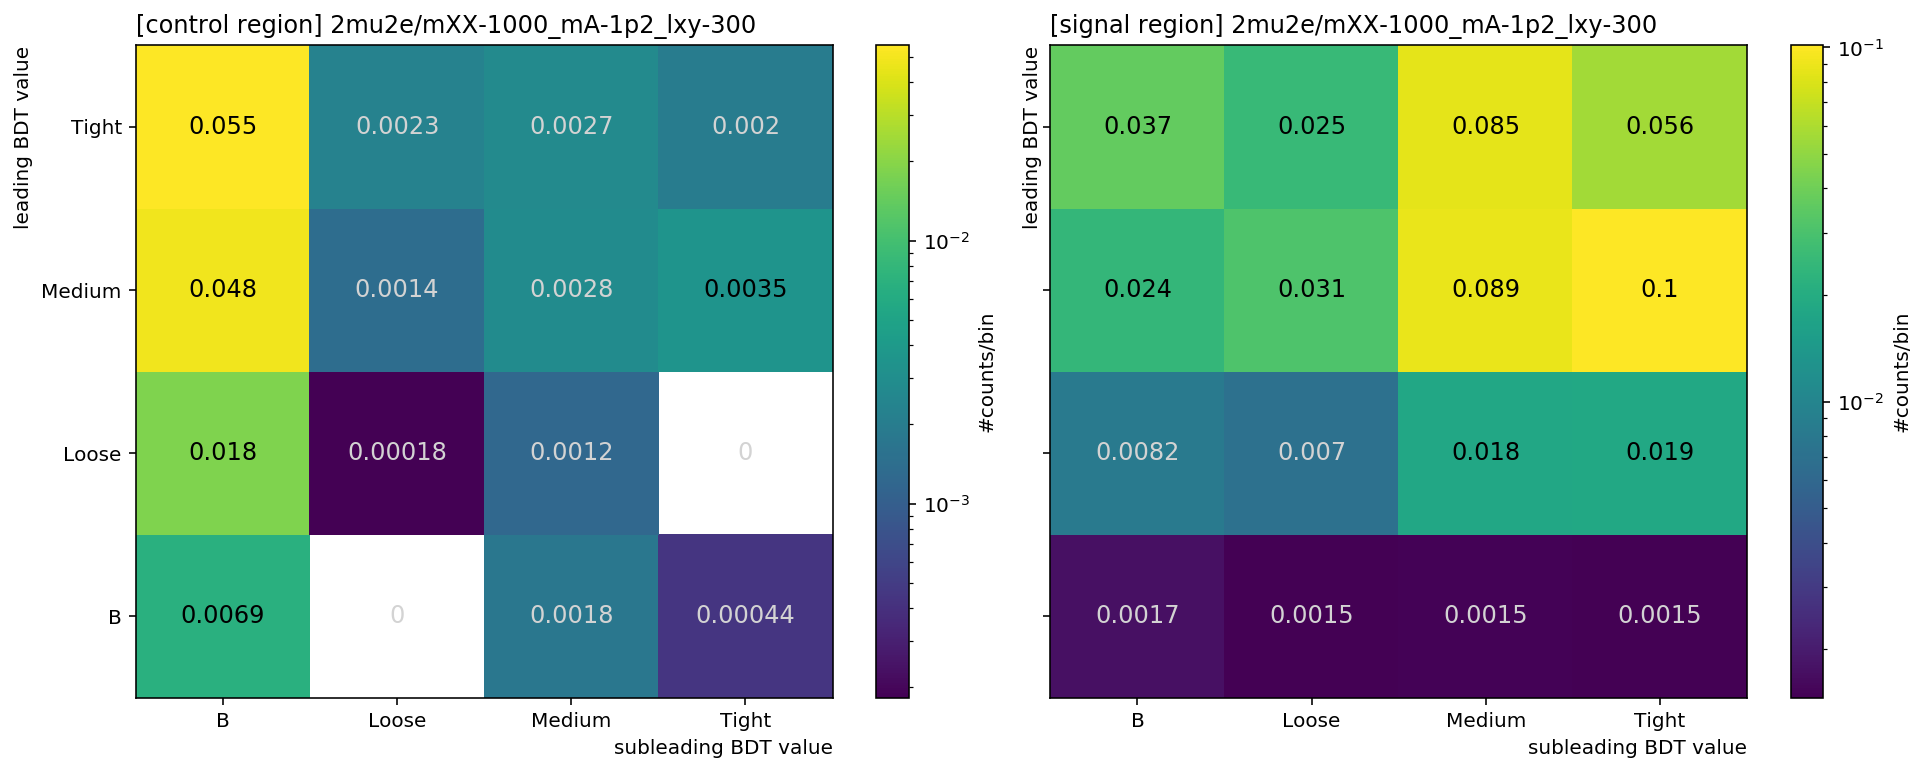

In [100]:
makeplot('2mu2e/mXX-1000_mA-1p2_lxy-300')

### mXX=1000 mA=5 lxy=300
2mu2e/mXX-1000_mA-5_lxy-300

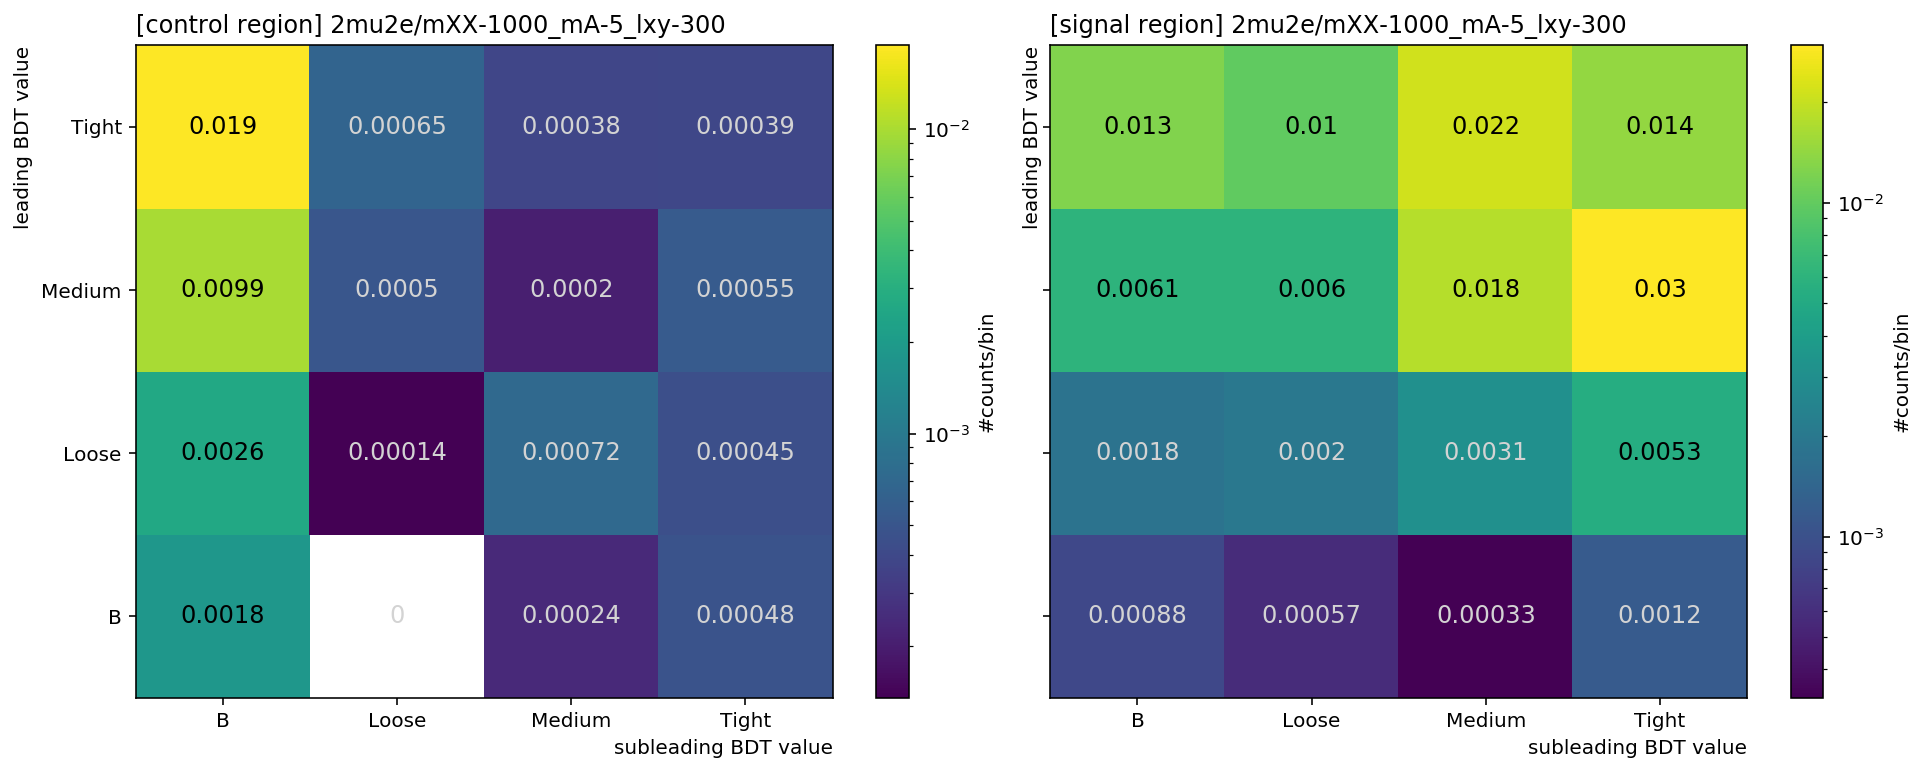

In [101]:
makeplot('2mu2e/mXX-1000_mA-5_lxy-300')